You can find on this document the data analysis, data selection, logistic and WLS fit. 
Mixed model is implemented in another file. 

# Imports

In [2]:
library(dplyr)
library(ggplot2)
#library(cat)
library(pROC)
library(tidyr)
library(nlme)
install.packages('bain')
library(bain)
install.packages('MuMIn')
library(MuMIn)
set.seed(123)


Attachement du package : 'dplyr'


Les objets suivants sont masqu'es depuis 'package:stats':

    filter, lag


Les objets suivants sont masqu'es depuis 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attachement du package : 'pROC'


Les objets suivants sont masqu'es depuis 'package:stats':

    cov, smooth, var



Attachement du package : 'nlme'


L'objet suivant est masqu'e depuis 'package:dplyr':

    collapse





Les packages binaires t'el'echarg'es sont dans
	/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T//RtmpZIjKAE/downloaded_packages

Les packages binaires t'el'echarg'es sont dans
	/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T//RtmpZIjKAE/downloaded_packages


In [4]:
df <- read.csv("data/data-agg.csv",header=T)
n <- nrow(df)
dfHeads <- df[,-c(2,4)] # heads to heads
dfTails <- df[,-c(1,3)] # tails to heads
dfTails[,1] <- dfTails[,2]-dfTails[,1] # tails to tails
names(dfHeads) <- names(dfTails) <- c("y", "m", "person", "coin")
start <- rep(c("heads","tails"),c(n,n))
df <- rbind(dfHeads,dfTails)
df$person <- factor(df$person); df$coin <- factor(df$coin); df$start <- factor(start) # nolint

In [5]:
df_long <- read.csv("data/data-long.csv",header=T)
df_time_agg <- read.csv("data/df-time-agg.csv",header=T)
df_time <- read.csv("data/df-time.csv",header=T)

# Data Analysis

**Number of tosses per participant:**

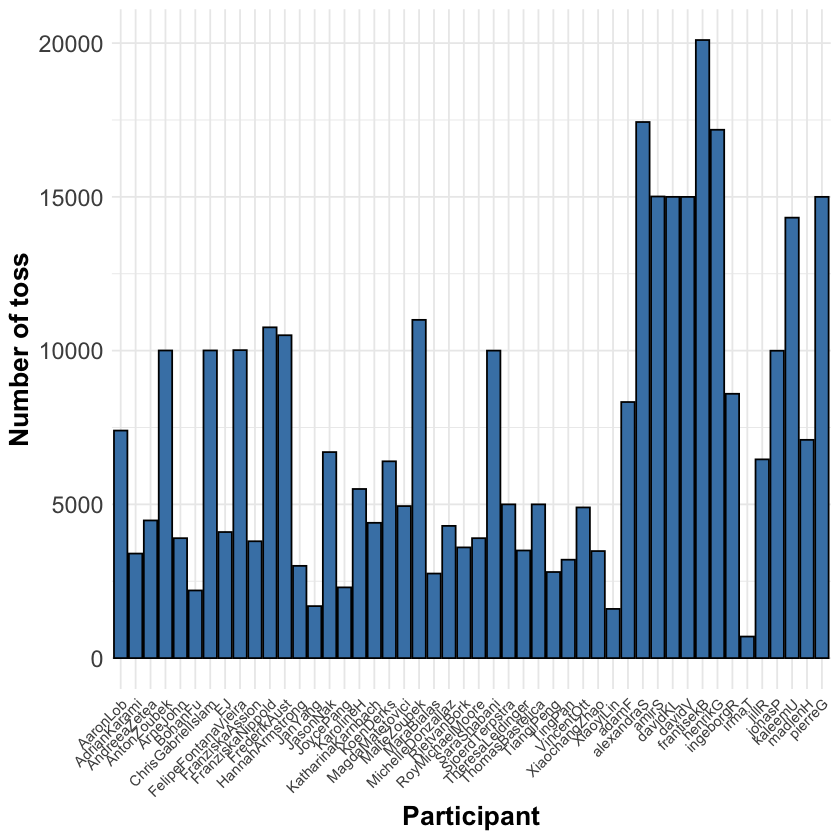

In [ ]:
nb_toss_per_person <- df %>%
    dplyr::select(m, person) %>%
    group_by(person) %>%
    summarise(m = sum(m))

ggplot(nb_toss_per_person, aes(x = person, y = m)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(
       x = "Participant",
       y = "Number of toss") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

**Number of tosses per coin:**

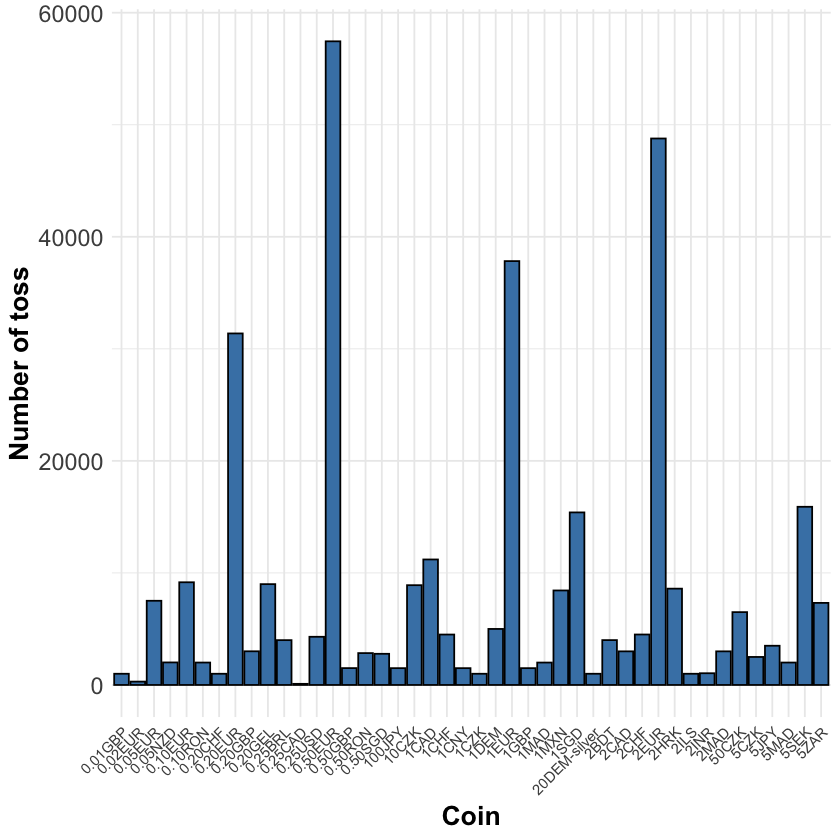

In [ ]:
nb_toss_per_coin <- df %>%
    dplyr::select(m, coin) %>%
    group_by(coin) %>%
    summarise(m = sum(m))

ggplot(nb_toss_per_coin, aes(x = coin, y = m)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black") +
  labs(
       x = "Coin",
       y = "Number of toss") +
  theme_minimal() +
 theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

As we can see, participants do not toss the same number of coins, so those who toss a lot will strongly influence the model’s results.

Similarly for the coins, those that appear less frequently have little influence on the model.

**Number of tosses per coin/participant combinations:** 

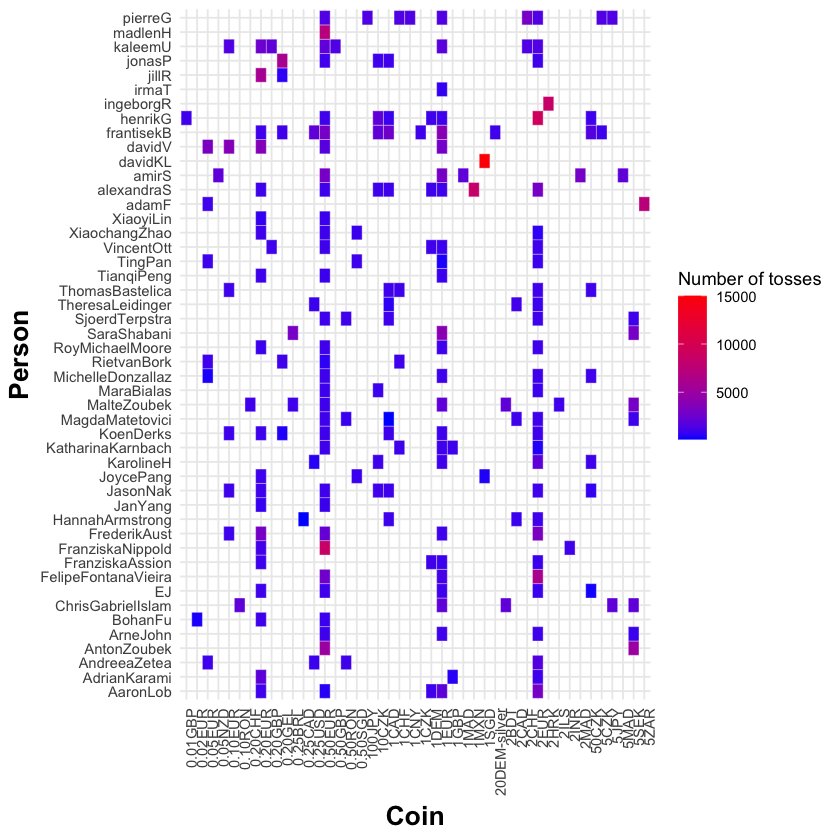

In [ ]:
heatmap_data <- df %>%
  group_by(person, coin) %>%
  summarise(total_lancers = sum(m), .groups = "drop")

ggplot(heatmap_data, aes(x = coin, y = person, fill = total_lancers)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Number of tosses") +
  labs(
       x = "Coin",
       y = "Person") +
   theme_minimal() +
   theme(
    axis.text.x = element_text( angle = 90, hjust = 1),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.00   49.67   50.60   50.45   51.20   53.79 

[1] 1.346065

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.28   49.95   50.57   50.71   51.45   55.65 

[1] 1.357797

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.06   49.30   50.50   50.14   51.28   53.84 

[1] 1.984118

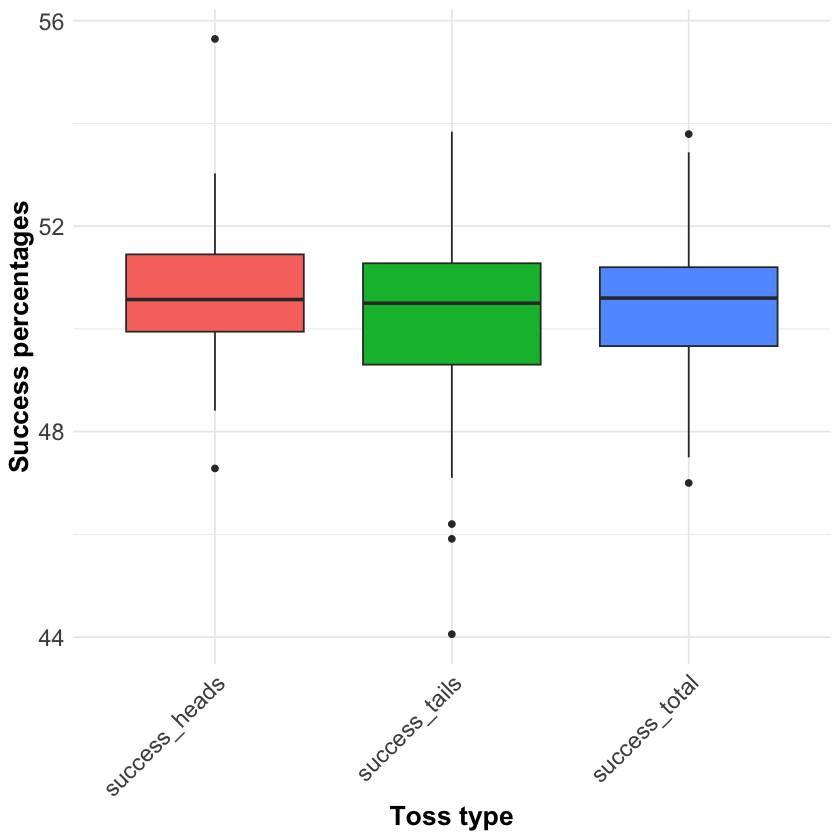

In [ ]:
percentages <- df %>%
  group_by(coin) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]),
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])
  ) %>%
  pivot_longer(cols = starts_with("success"), names_to = "type", values_to = "percentage")


ggplot(percentages, aes(x = type, y = percentage, fill = type)) +
  geom_boxplot() +
  labs(
    #title = "Success percentages by toss type and coin",
    x = "Toss type",
    y = "Success percentages"
  ) +
  theme_minimal() +
   theme(
    axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"
  )

summary(percentages$percentage[percentages$type == "success_total"])
sd(percentages$percentage[percentages$type == "success_total"])
summary(percentages$percentage[percentages$type == "success_heads"])
sd(percentages$percentage[percentages$type == "success_heads"])
summary(percentages$percentage[percentages$type == "success_tails"])
sd(percentages$percentage[percentages$type == "success_tails"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  48.75   50.04   50.52   51.05   51.71   60.07 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.53   49.99   50.75   51.02   51.80   58.17 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.86   49.75   50.63   51.05   51.75   61.82 

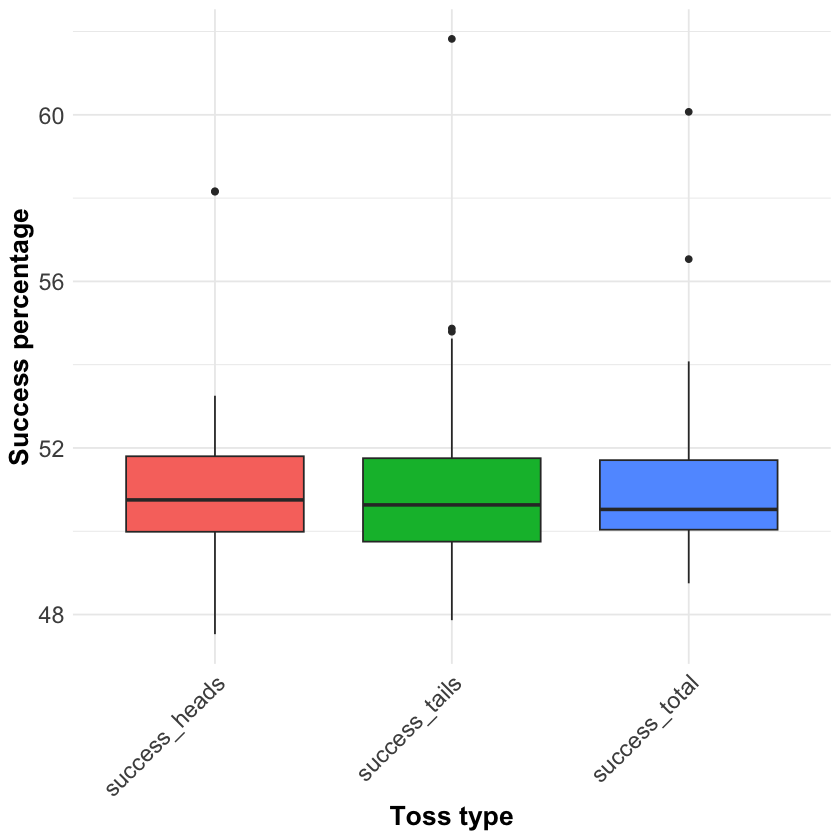

In [ ]:
percentages <- df %>%
  group_by(person) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]),
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])
  ) %>%
  pivot_longer(cols = starts_with("success"), names_to = "type", values_to = "percentage")


ggplot(percentages, aes(x = type, y = percentage, fill = type)) +
  geom_boxplot() +
  labs(
    #title = "Success percentages by toss type and participant",
    x = "Toss type",
    y = "Success percentage"
  ) +
  theme_minimal() +
   theme(
    axis.text.x = element_text(size= 14, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"
  )

summary(percentages$percentage[percentages$type == "success_total"])
summary(percentages$percentage[percentages$type == "success_heads"])
summary(percentages$percentage[percentages$type == "success_tails"])

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.56   49.50   50.60   50.83   51.80   62.10 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  42.73   49.50   50.69   50.79   51.99   61.45 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.06   48.98   50.50   50.77   52.08   65.94 

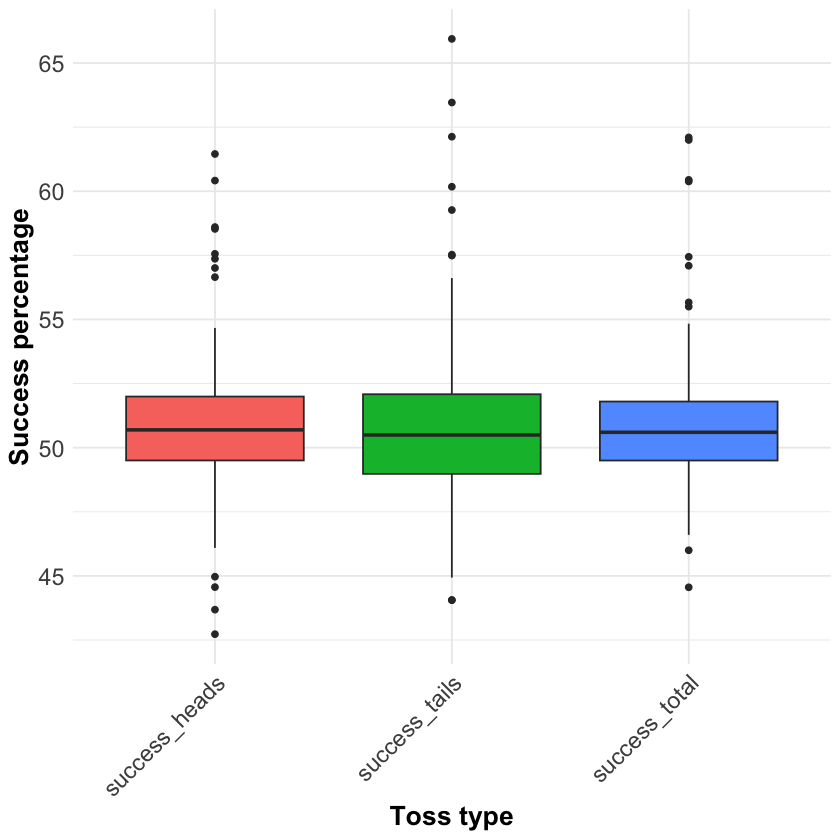

In [ ]:
percentages <- df %>%
  group_by(person, coin) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]),
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])
  ) %>%
  pivot_longer(cols = starts_with("success"), names_to = "type", values_to = "percentage")

ggplot(percentages, aes(x = type, y = percentage, fill = type)) +
  geom_boxplot() +
  labs(
    #title = "Success percentages by toss type and participant",
    x = "Toss type",
    y = "Success percentage"
  ) +
  theme_minimal() +
   theme(
    axis.text.x = element_text(size= 14, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    legend.position = "none"
  )

cat('Summary number of successes:', '\n')
summary(percentages$percentage[percentages$type == "success_total"])
cat('Summary number of successes (heads only):', '\n')
summary(percentages$percentage[percentages$type == "success_heads"])
cat('Summary number of successes (tails only):', '\n')
summary(percentages$percentage[percentages$type == "success_tails"])

Thus outliers are the two largest in the persons (Tianqi Peng and JanYang) and the largest and the smallest in the coins (0.50SGD and 0.02EUR) and some person/coin combinations

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


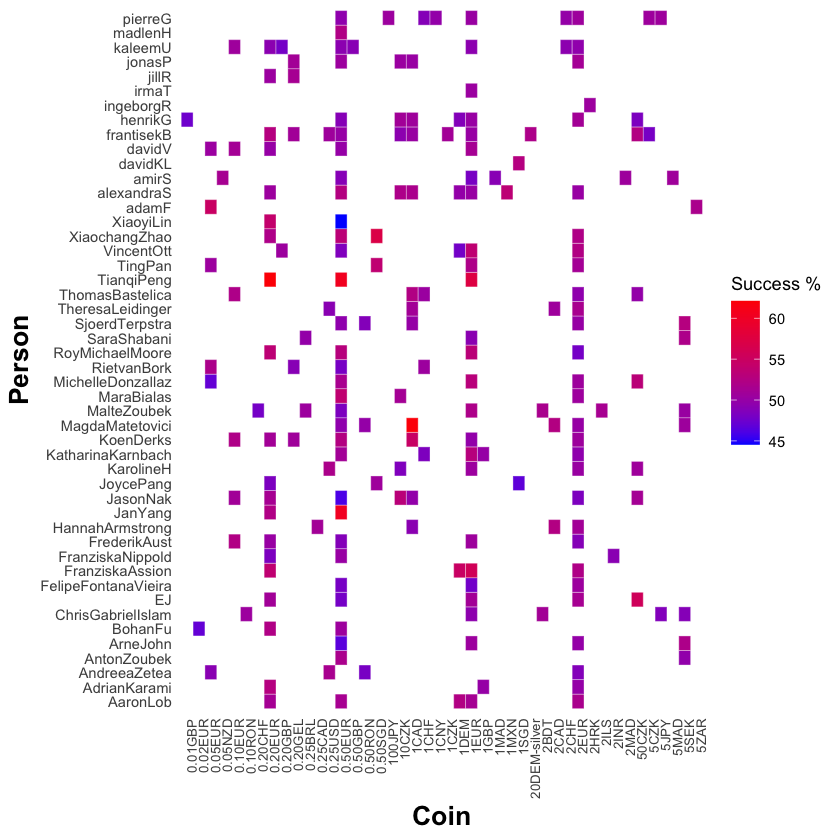

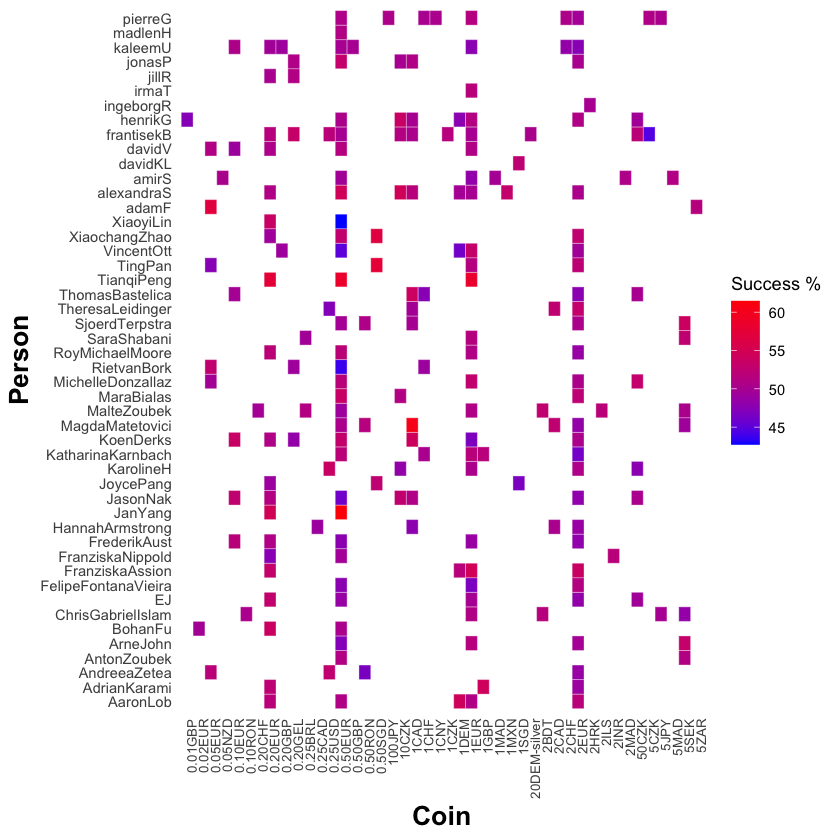

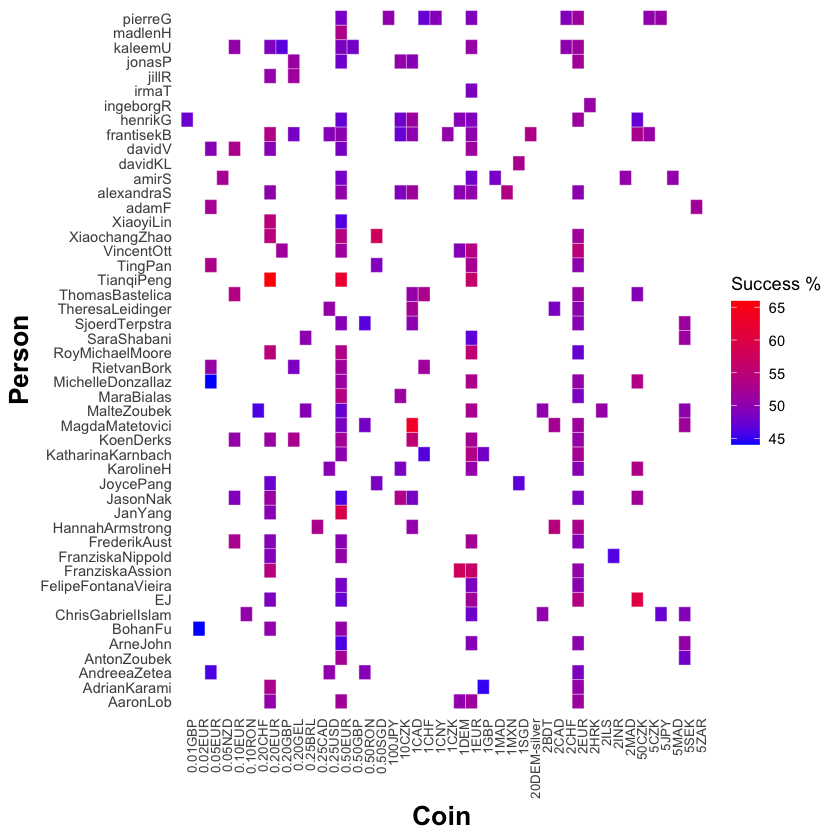

In [ ]:
percentages <- df %>%
  group_by(person, coin) %>%
  summarise(
    success_total = 100 * sum(y) / sum(m),
    success_heads = 100 * sum(y[start == "heads"]) / sum(m[start == "heads"]),
    success_tails = 100 * sum(y[start == "tails"]) / sum(m[start == "tails"])
  ) %>%
  pivot_longer(
    cols = starts_with("success"),
    names_to = "type",
    values_to = "percentage"
  )

ggplot(filter(percentages, type == "success_total"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Total Success Percentage by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
   theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

ggplot(filter(percentages, type == "success_heads"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Success Percentage (Heads Start) by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
   theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

ggplot(filter(percentages, type == "success_tails"), aes(x = coin, y = person, fill = percentage)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red", name = "Success %") +
  labs(
    #title = "Success Percentage (Tails Start) by Person and Coin",
    x = "Coin",
    y = "Person"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 8,  angle = 90, hjust = 1),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  ) + 
  theme(
    panel.grid = element_blank()
  )

# Data selection


As some participant ou some coin were tossed a larger number of time than other, they will have more impact on regression we want to do. So, to limit that regression, we want to take a maximum number of tosses per combination person/coin. The goal is that all data are under 4/(number of data) -> Cook's distance

For the logistic regression (not for WLS or mixed model), we take the first 2000 tosses per participant/coin combination

In [ ]:
#Remove outliers first
df <- df[df$person != "TianqiPeng", ]
df <- df[df$person != "JanYang", ]
df <- df[df$coin != "0.50SGD", ]
df <- df[df$coin != "0.02EUR", ]
df <- subset(df, !(person == "MagdaMatetovici" & coin == "1CAD"))
df <- subset(df, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df <- subset(df, !(person == "FranziskaAssion" & coin == "1EUR"))
df <- subset(df, !(person == "EJ" & coin == "50CZK"))
df <- subset(df, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df <- subset(df, !(person == "JasonNak" & coin == "0.50EUR"))

df_long <- df_long[df_long$person != "TianqiPeng", ]
df_long <- df_long[df_long$person != "JanYang", ]
df_long <- df_long[df_long$coin != "0.50SGD", ]
df_long <- df_long[df_long$coin != "0.02EUR", ]
df_long <- subset(df_long, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_long <- subset(df_long, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_long <- subset(df_long, !(person == "FranziskaAssion" & coin == "1EUR"))
df_long <- subset(df_long, !(person == "EJ" & coin == "50CZK"))
df_long <- subset(df_long, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_long <- subset(df_long, !(person == "JasonNak" & coin == "0.50EUR"))

df_time <- df_time[df_time$person != "TianqiPeng", ]
df_time <- df_time[df_time$person != "JanYang", ]
df_time <- df_time[df_time$coin != "0.50SGD", ]
df_time <- df_time[df_time$coin != "0.02EUR", ]
df_time <- subset(df_time, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_time <- subset(df_time, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_time <- subset(df_time, !(person == "FranziskaAssion" & coin == "1EUR"))
df_time <- subset(df_time, !(person == "EJ" & coin == "50CZK"))
df_time <- subset(df_time, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_time <- subset(df_time, !(person == "JasonNak" & coin == "0.50EUR"))

df_time_agg <- df_time_agg[df_time_agg$person != "TianqiPeng", ]
df_time_agg <- df_time_agg[df_time_agg$person != "JanYang", ]
df_time_agg <- df_time_agg[df_time_agg$coin != "0.50SGD", ]
df_time_agg <- df_time_agg[df_time_agg$coin != "0.02EUR", ]
df_time_agg <- subset(df_time_agg, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_time_agg <- subset(df_time_agg, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_time_agg <- subset(df_time_agg, !(person == "FranziskaAssion" & coin == "1EUR"))
df_time_agg <- subset(df_time_agg, !(person == "EJ" & coin == "50CZK"))
df_time_agg <- subset(df_time_agg, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_time_agg <- subset(df_time_agg, !(person == "JasonNak" & coin == "0.50EUR"))


In [17]:
sampled_data <- df_time_agg %>%
  group_by(person, coin) %>%
  # Calculate the cumulative number of tosses
  mutate(cumulative_tosses = cumsum(to - from + 1)) %>%
  # Identify rows within the first 2000 tosses
  filter(cumulative_tosses <= 2000 | lag(cumulative_tosses, default = 0) < 2000) %>%
  mutate(tails_tails = N_start_tails_up - tails_heads) %>%
  ungroup()

print(sampled_data)


# A tibble: 2,480 x 14
   heads_heads tails_heads N_start_heads_up N_start_tails_up same_side     N
         <int>       <int>            <int>            <int>     <int> <int>
 1          28          20               48               52        60   100
 2          19          24               43               57        52   100
 3          20          28               48               52        44   100
 4          34          20               54               46        60   100
 5          20          26               46               54        48   100
 6          22          25               47               53        50   100
 7          29          26               55               45        48   100
 8          16          22               39               61        55   100
 9          29          25               54               46        50   100
10          27          24               51               49        52   100
# i 2,470 more rows
# i 8 more variables: person <chr

In [18]:
sum(sampled_data$N_start_heads_up + sampled_data$N_start_tails_up)
sum(sampled_data$N_start_heads_up + sampled_data$N_start_tails_up)/350757

[1] 248507

[1] 0.7084876

In [19]:
nb_toss_per_person_1 <- sampled_data %>%
    dplyr::select(N, person) %>%
    group_by(person) %>%
    summarise(N = sum(N))

nb_toss_per_person_original <- df_time_agg %>%
    dplyr::select(N, person) %>%
    group_by(person) %>%
    summarise(N = sum(N))


print("Max, Min, Mean, Std of tosses per person original data:")
max(nb_toss_per_person_original$N)
min(nb_toss_per_person_original$N)
mean(nb_toss_per_person_original$N)
sd(nb_toss_per_person_original$N)
print("Max, Min, Mean, Std of tosses per person sampled data:")
max(nb_toss_per_person_1$N)
min(nb_toss_per_person_1$N)
mean(nb_toss_per_person_1$N)
sd(nb_toss_per_person_1$N)

[1] "Max, Min, Mean, Std of tosses per person original data:"


[1] 20100

[1] 700

[1] 7393.152

[1] 4981.067

[1] "Max, Min, Mean, Std of tosses per person sampled data:"


[1] 16600

[1] 700

[1] 5402.326

[1] 3678.316

In [20]:
nb_toss_per_coin_1 <- sampled_data %>%
    dplyr::select(N, coin) %>%
    group_by(coin) %>%
    summarise(N = sum(N))

nb_toss_per_coin_original <- df_time_agg %>%
    dplyr::select(N, coin) %>%
    group_by(coin) %>%
    summarise(N = sum(N))


print("Max, Min, Mean, Std of tosses per coin original data:")
max(nb_toss_per_coin_original$N)
min(nb_toss_per_coin_original$N)
mean(nb_toss_per_coin_original$N)
sd(nb_toss_per_coin_original$N)
print("Max, Min, Mean, Std of tosses per coin sampled data:")
max(nb_toss_per_coin_1$N)
min(nb_toss_per_coin_1$N)
mean(nb_toss_per_coin_1$N)
sd(nb_toss_per_coin_1$N)

[1] "Max, Min, Mean, Std of tosses per coin original data:"


[1] 53754

[1] 100

[1] 8097.262

[1] 12137.68

[1] "Max, Min, Mean, Std of tosses per coin sampled data:"


[1] 36206

[1] 100

[1] 5916.833

[1] 8702.038

In [ ]:
sampled_data_model <- sampled_data %>%
    mutate(y = heads_heads + tails_tails) %>%
    rename(m=N) %>%
    dplyr::select(y,m,person,coin) %>%
    group_by(person, coin) %>%
    summarize(m=sum(m), y=sum(y))

print(sampled_data_model)

table(sampled_data_model$m)

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


# A tibble: 197 x 4
# Groups:   person [46]
   person       coin        m     y
   <chr>        <chr>   <int> <int>
 1 AaronLob     0.20EUR  1000   512
 2 AaronLob     0.50EUR   500   257
 3 AaronLob     1DEM     1000   524
 4 AaronLob     1EUR     1900   973
 5 AaronLob     2EUR     2000  1031
 6 AdrianKarami 0.20EUR  1900  1000
 7 AdrianKarami 1GBP      500   250
 8 AdrianKarami 2EUR     1000   499
 9 AndreeaZetea 0.05EUR  1000   491
10 AndreeaZetea 0.25USD   900   464
# i 187 more rows



 100  300  400  500  600  602  700  701  844  900  905  945 1000 1003 1046 1100 
   1    2    3    3    3    1    2    1    1   13    1    1   92    1    1    1 
1105 1201 1500 1502 1503 1504 1505 1577 1600 1697 1802 1900 2000 2001 2002 2003 
   1    1    8    1    1    1    1    1    1    1    1    2   27    6    1    2 
2005 2006 2008 2011 2023 2025 2028 2033 2039 
   2    3    1    1    2    1    1    2    1 

## Adding 'start'

In [22]:
sampled_data_heads <- sampled_data[c('heads_heads','N_start_heads_up','person','coin')]
names(sampled_data_heads) <-  c("y", "m", "person", "coin")
sampled_data_heads$start <- "heads"

sampled_data_tails <- sampled_data[c('tails_tails','N_start_tails_up','person','coin')]
names(sampled_data_tails) <-  c("y", "m","person", "coin")
sampled_data_tails$start <- "tails"

sampled_data1 <- rbind(sampled_data_heads, sampled_data_tails)
sampled_data_model1 <- sampled_data1 %>%
    group_by(person, coin, start) %>%
    summarize(m=sum(m), y=sum(y))

`summarise()` has grouped output by 'person', 'coin'. You can override using
the `.groups` argument.


# Model with new data

## Model selection with new data

In [80]:
data_used = sampled_data_model1

glmIntercept1 = glm(cbind(y,m-y)~1,family=binomial,data=data_used)
#summary(glmIntercept) 

glmTotal1Nested = glm(cbind(y,m-y)~1+person/coin,family=binomial,data=data_used)
#summary(glmTotal1Nested)

glmTotal1 = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=data_used)
#summary(glmTotal1)

glmPerson1 = glm(cbind(y,m-y)~1+person,family=binomial,data=data_used)
#summary(glmPerson1)

glmCoin1 = glm(cbind(y,m-y)~1+coin,family=binomial,data=data_used)
#summary(glmCoin1)

glmCoinstart1 = glm(cbind(y,m-y)~1+coin + start,family=binomial,data=data_used)

glmStart1 = glm(cbind(y,m-y)~1 +start,family=binomial,data=data_used)

glmPersonstart1 = glm(cbind(y,m-y)~1+person + start,family=binomial,data=data_used)

glmAll1  = glm(cbind(y,m-y)~ coin + start + person,family=binomial,data=data_used)

### Forward/Backward selection

In [81]:
best_model <- step(glm(cbind(y,m-y)~.,family=binomial,data=data_used), direction="both") 
summary(best_model) # only person
best_model$anova

Start:  AIC=3149.89
cbind(y, m - y) ~ person + coin + start

         Df Deviance    AIC
- coin   40   350.35 3128.1
- start   1   293.26 3149.0
<none>        292.13 3149.9
- person 44   402.91 3172.7

Step:  AIC=3128.12
cbind(y, m - y) ~ person + start

         Df Deviance    AIC
- start   1   351.42 3127.2
<none>        350.35 3128.1
+ coin   40   292.13 3149.9
- person 45   486.41 3174.2

Step:  AIC=3127.18
cbind(y, m - y) ~ person

         Df Deviance    AIC
<none>        351.42 3127.2
+ start   1   350.35 3128.1
+ coin   40   293.26 3149.0
- person 45   487.42 3173.2



Call:
glm(formula = cbind(y, m - y) ~ person, family = binomial, data = data_used)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.060644   0.025011   2.425 0.015324 *  
personAdrianKarami        -0.002981   0.042462  -0.070 0.944040    
personAndreeaZetea        -0.091470   0.038977  -2.347 0.018938 *  
personAntonZoubek          0.008349   0.040327   0.207 0.835979    
personArneJohn            -0.073977   0.040636  -1.820 0.068684 .  
personBohanFu             -0.003786   0.052274  -0.072 0.942260    
personChrisGabrielIslam   -0.073237   0.032022  -2.287 0.022189 *  
personEJ                  -0.050387   0.040635  -1.240 0.214984    
personFelipeFontanaVieira -0.098311   0.037343  -2.633 0.008472 ** 
personFranziskaAssion      0.083051   0.044856   1.852 0.064093 .  
personFranziskaNippold    -0.063512   0.039769  -1.597 0.110266    
personFrederikAust        -0.081644   0.033550  -2.433 0.014954 *  
personHannahArmst

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,307,292.1330,3149.894
- coin,40,58.220809,347,350.3538,3128.115
- start,1,1.062793,348,351.4166,3127.178


In [ ]:
#Is start significant?
anova(glmPerson1, glmPersonstart1, test="LRT") #-> Nope

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,348,351.4166,NA,NA,NA
2,347,350.3538,1,1.062793,0.3025791


In [ ]:
tab1 <- AIC(glmIntercept1, glmTotal1Nested, glmTotal1, glmPerson1,
    glmCoin1, glmCoinstart1, glmStart1, glmPersonstart1, glmAll1)
tab2 <- AICc(glmIntercept1, glmTotal1Nested, glmTotal1, glmPerson1,
    glmCoin1, glmCoinstart1, glmStart1, glmPersonstart1, glmAll1)
tab3 <- BIC(glmIntercept1, glmTotal1Nested, glmTotal1, glmPerson1,
    glmCoin1, glmCoinstart1, glmStart1, glmPersonstart1, glmAll1)

In [30]:
tab_lr_selection <- cbind(tab1, tab2, tab3)
print(tab_lr_selection)

                 df      AIC  df     AICc  df      BIC
glmIntercept1     1 3173.179   1 3173.189   1 3177.155
glmTotal1Nested 197 3258.579 197 3656.599 197 4041.920
glmTotal1        86 3149.025  86 3197.768  86 3490.991
glmPerson1       46 3127.178  46 3139.639  46 3310.090
glmCoin1         42 3171.812  42 3182.103  42 3338.819
glmCoinstart1    43 3172.672  43 3183.483  43 3343.655
glmStart1         2 3174.167   2 3174.198   2 3182.120
glmPersonstart1  47 3128.115  47 3141.155  47 3315.004
glmAll1          87 3149.894  87 3199.933  87 3495.837


In [88]:
anova(glmPerson, glmTotal1Nested)

,Resid. Df,Resid. Dev,Df,Deviance
,<dbl>,<dbl>,<dbl>,<dbl>
1,348,337.6467,NA,NA
2,197,180.8173,151,156.8294


## Model fit

In [31]:
glm_model1 <- glm(cbind(y,m-y)~ 1+person ,family=binomial,data=sampled_data_model1)

In [32]:
print(summary(glm_model1))


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = sampled_data_model1)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.060644   0.025011   2.425 0.015324 *  
personAdrianKarami        -0.002981   0.042462  -0.070 0.944040    
personAndreeaZetea        -0.091470   0.038977  -2.347 0.018938 *  
personAntonZoubek          0.008349   0.040327   0.207 0.835979    
personArneJohn            -0.073977   0.040636  -1.820 0.068684 .  
personBohanFu             -0.003786   0.052274  -0.072 0.942260    
personChrisGabrielIslam   -0.073237   0.032022  -2.287 0.022189 *  
personEJ                  -0.050387   0.040635  -1.240 0.214984    
personFelipeFontanaVieira -0.098311   0.037343  -2.633 0.008472 ** 
personFranziskaAssion      0.083051   0.044856   1.852 0.064093 .  
personFranziskaNippold    -0.063512   0.039769  -1.597 0.110266    
personFrederikAust        -0.081644   0.033550  -2.433 0.014954 * 

## Model checking

In [34]:
residuals_deviance1 <- residuals(glm_model1, type = "deviance")
residuals_pearson1 <- residuals(glm_model1, type = "pearson")

### Linearity

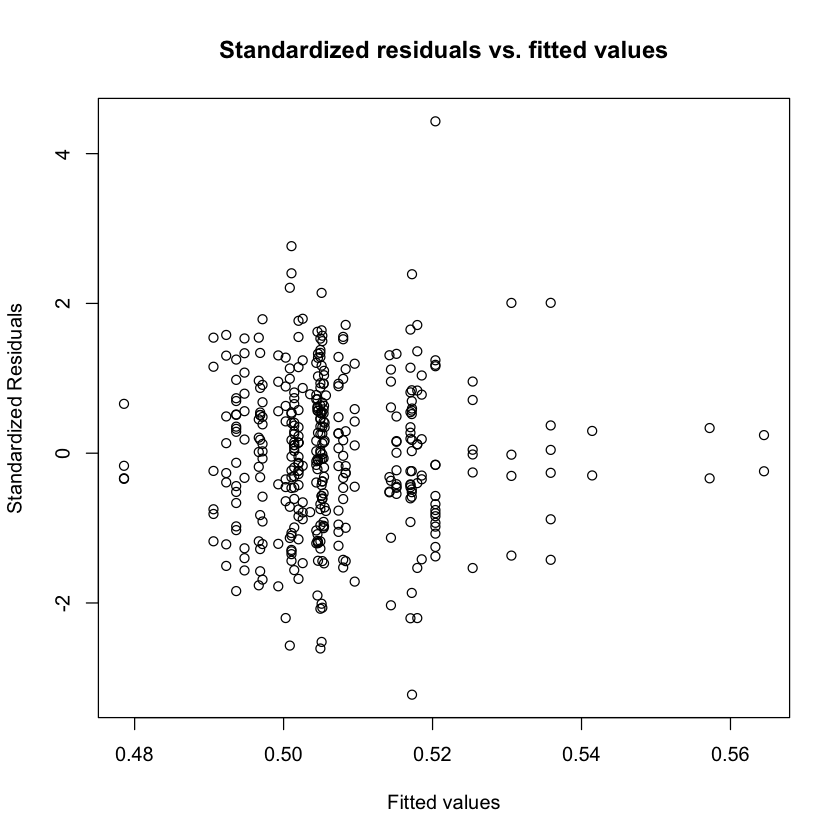

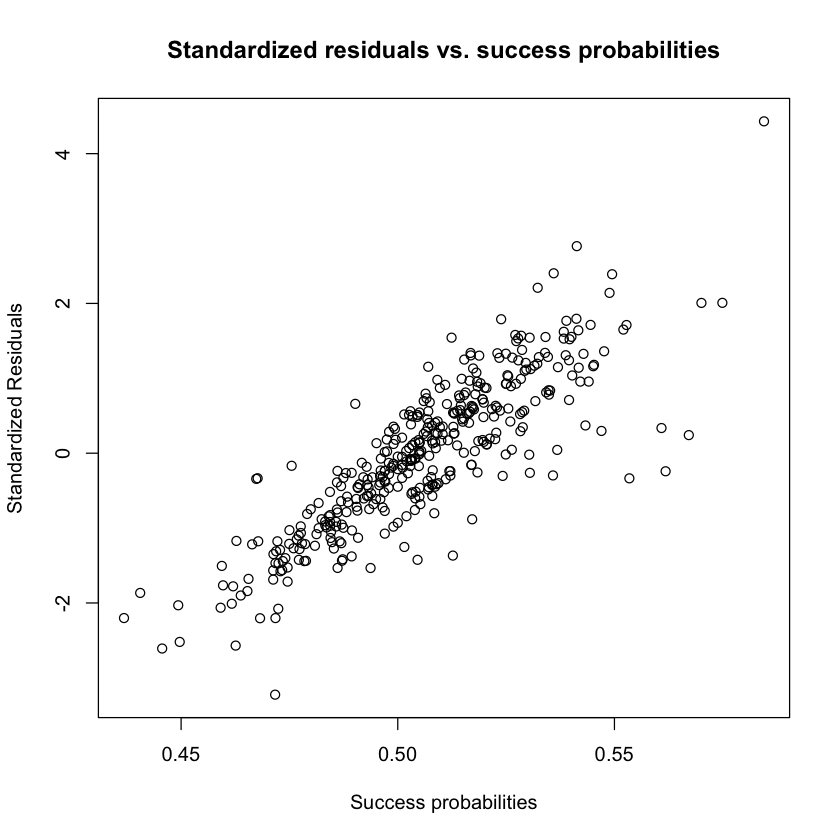

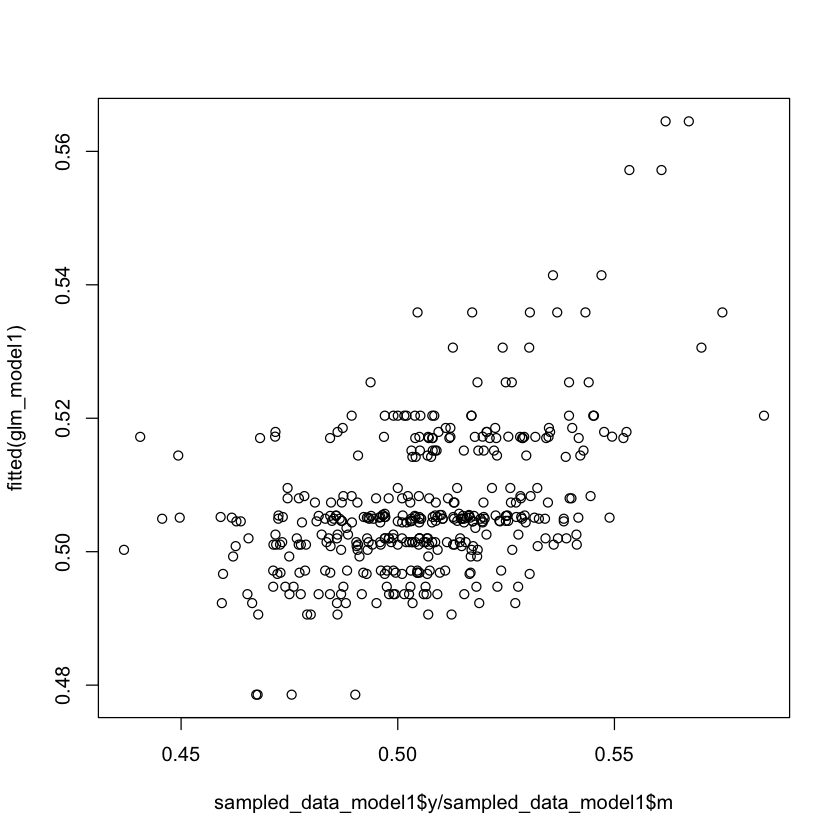

In [79]:
plot(fitted(glm_model1), rstandard(glm_model1), main="Standardized residuals vs. fitted values", xlab="Fitted values", ylab="Standardized Residuals")
plot(sampled_data_model1$y/sampled_data_model1$m, rstandard(glm_model1), main="Standardized residuals vs. success probabilities", xlab="Success probabilities", ylab="Standardized Residuals")
plot(sampled_data_model1$y/sampled_data_model1$m, fitted(glm_model1))

### Response distribution 

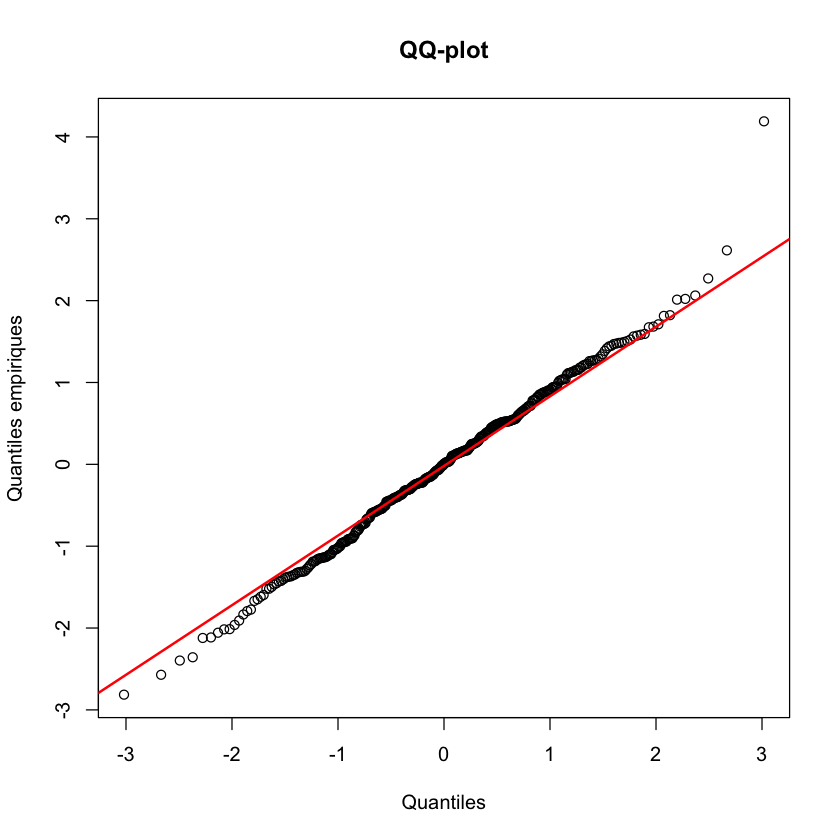

In [38]:
qqnorm(residuals_deviance1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance1, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std1 <- residuals_deviance1 / sqrt(1 - hatvalues(glm_model1))

#qqnorm(residuals_d_std1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

#qqline(residuals_d_std1, col = "red", lwd = 2)
# Not a big difference between them 


### Independence

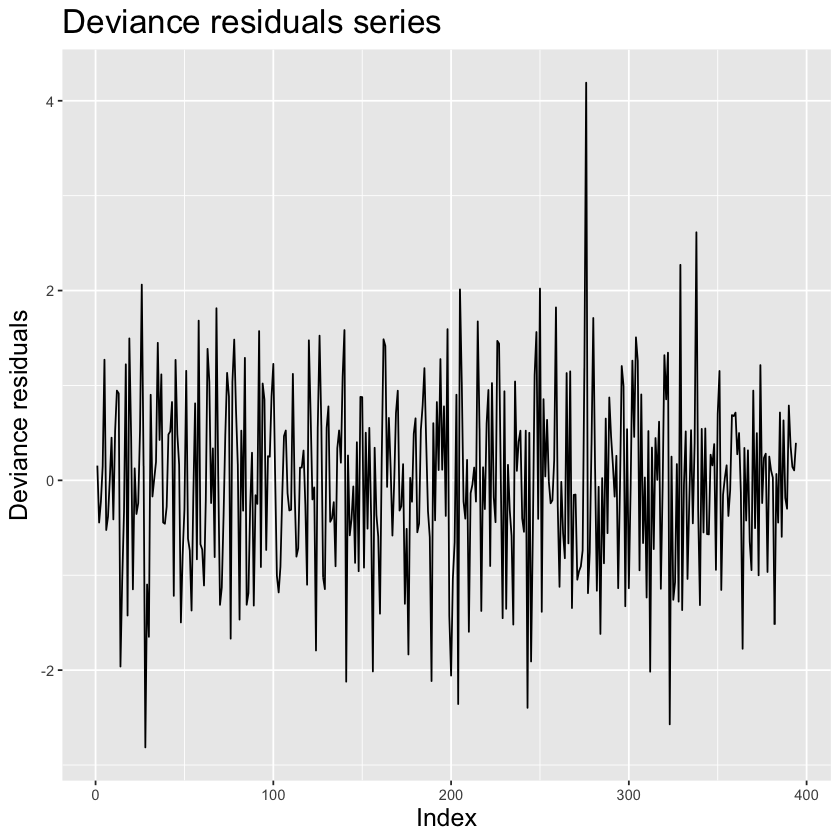

In [40]:
residuals_df1 <- data.frame(Residuals = residuals_deviance1, Index = seq_along(residuals_deviance1))
ggplot(residuals_df1, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

### Cook's distance

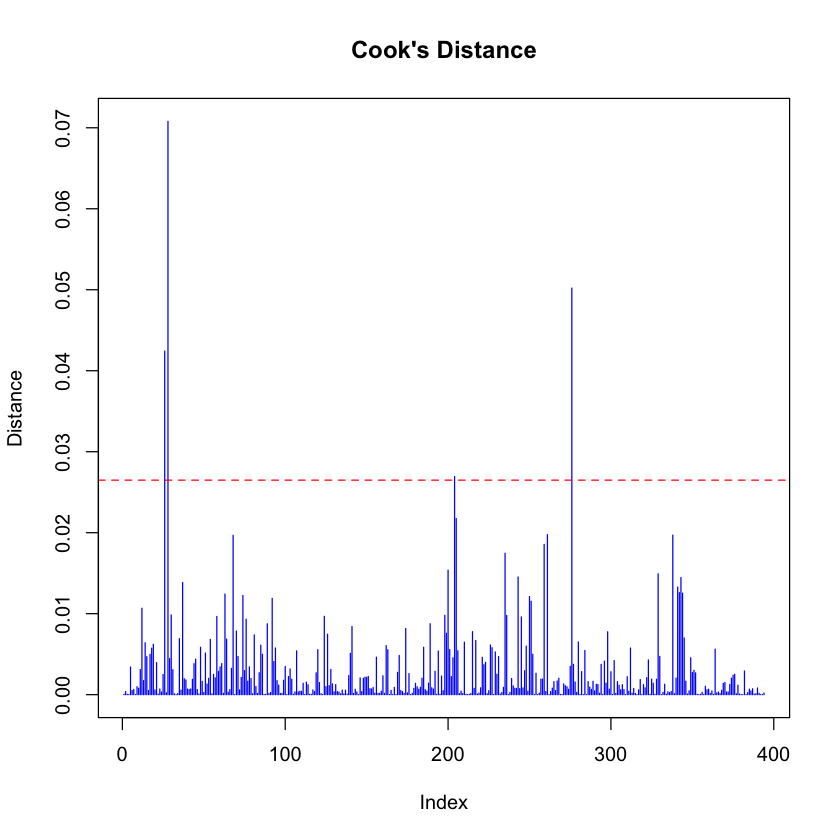

In [ ]:
cooks_distance1 <- cooks.distance(glm_model1)

plot(cooks_distance1, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 8/(nrow(sampled_data_model1)- 2*length(unique(sampled_data_model1$person))), col = "red", lty = 2) # rule of thumb 

In [94]:
#threshold <- 4 / nrow(sampled_data_model1)
threshold <- 8/(nrow(sampled_data_model1)- 2*length(unique(sampled_data_model1$person)))
influential_points <- which(cooks_distance1 > threshold)
influential_data <- sampled_data_model1[influential_points, ]
print(influential_data)

# A tibble: 4 x 5
# Groups:   person, coin [4]
  person      coin    start     m     y
  <chr>       <chr>   <chr> <int> <int>
1 AntonZoubek 0.50EUR tails  1021   561
2 AntonZoubek 5SEK    tails   954   450
3 SaraShabani 1EUR    tails   949   439
4 alexandraS  1MXN    tails  1059   619


## Performance

In [43]:
pred_probs1 <- predict(glm_model1, type = "response")
print(mean(pred_probs1))

[1] 0.506663


### ROC curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6874

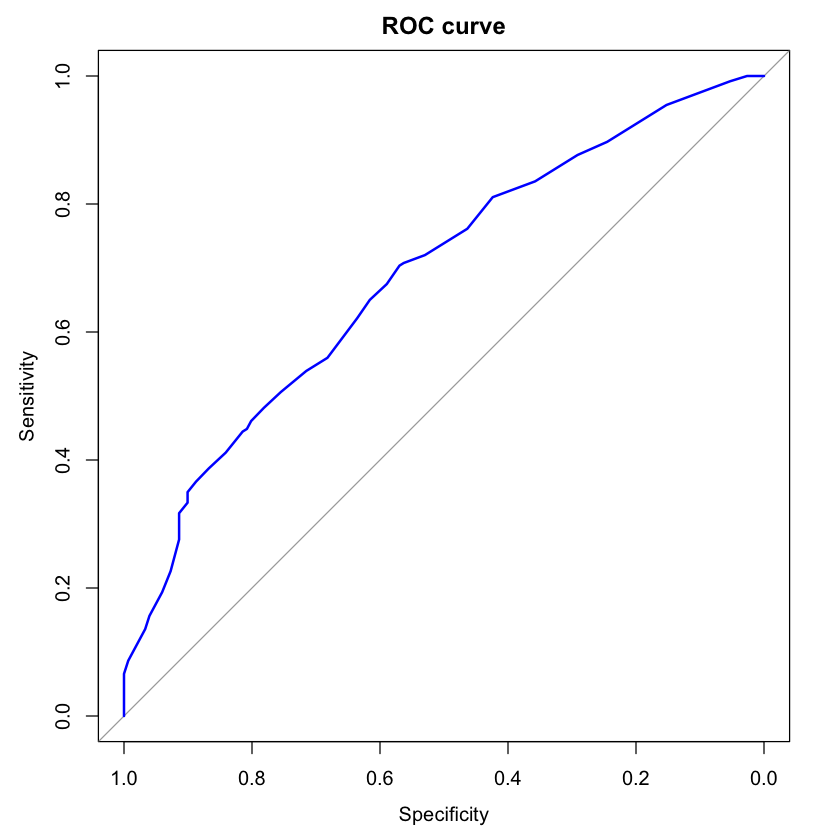

In [78]:
actual_classes1 <- ifelse(sampled_data_model1$y > (sampled_data_model1$m / 2), 1, 0)

roc_curve1 <- roc(actual_classes1, pred_probs1)

plot(roc_curve1, main = "ROC curve", col = "blue", lwd = 2)

auc(roc_curve1)

### Confusion matrix/ Accuracy

In [ ]:
pred_successes1 <- pred_probs1 * sampled_data_model1$m

pred_classes1 <- ifelse(pred_successes1 > (sampled_data_model1$m / 2), 1, 0)

actual_classes1 <- ifelse(sampled_data_model1$y > (sampled_data_model1$m / 2), 1, 0)

confusion_matrix1 <- table(Predicted = pred_classes1, Actual = actual_classes1)

accuracy1 <- sum(diag(confusion_matrix1)) / sum(confusion_matrix1)
print(paste("Accuracy: ", accuracy1))

[1] "Accuracy:  0.652284263959391"


# Model with all data

In [47]:
#Remove outliers first
df <- df[df$person != "TianqiPeng", ]
df <- df[df$person != "JanYang", ]
df <- df[df$coin != "0.50SGD", ]
df <- df[df$coin != "0.02EUR", ]
df <- subset(df, !(person == "MagdaMatetovici" & coin == "1CAD"))
df <- subset(df, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df <- subset(df, !(person == "FranziskaAssion" & coin == "1EUR"))
df <- subset(df, !(person == "EJ" & coin == "50CZK"))
df <- subset(df, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df <- subset(df, !(person == "JasonNak" & coin == "0.50EUR"))

df_long <- df_long[df_long$person != "TianqiPeng", ]
df_long <- df_long[df_long$person != "JanYang", ]
df_long <- df_long[df_long$coin != "0.50SGD", ]
df_long <- df_long[df_long$coin != "0.02EUR", ]
df_long <- subset(df_long, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_long <- subset(df_long, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_long <- subset(df_long, !(person == "FranziskaAssion" & coin == "1EUR"))
df_long <- subset(df_long, !(person == "EJ" & coin == "50CZK"))
df_long <- subset(df_long, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_long <- subset(df_long, !(person == "JasonNak" & coin == "0.50EUR"))

df_time <- df_time[df_time$person != "TianqiPeng", ]
df_time <- df_time[df_time$person != "JanYang", ]
df_time <- df_time[df_time$coin != "0.50SGD", ]
df_time <- df_time[df_time$coin != "0.02EUR", ]
df_time <- subset(df_time, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_time <- subset(df_time, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_time <- subset(df_time, !(person == "FranziskaAssion" & coin == "1EUR"))
df_time <- subset(df_time, !(person == "EJ" & coin == "50CZK"))
df_time <- subset(df_time, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_time <- subset(df_time, !(person == "JasonNak" & coin == "0.50EUR"))

df_time_agg <- df_time_agg[df_time_agg$person != "TianqiPeng", ]
df_time_agg <- df_time_agg[df_time_agg$person != "JanYang", ]
df_time_agg <- df_time_agg[df_time_agg$coin != "0.50SGD", ]
df_time_agg <- df_time_agg[df_time_agg$coin != "0.02EUR", ]
df_time_agg <- subset(df_time_agg, !(person == "MagdaMatetovici" & coin == "1CAD"))
df_time_agg <- subset(df_time_agg, !(person == "XiaochangZhao" & coin == "0.50SGD"))
df_time_agg <- subset(df_time_agg, !(person == "FranziskaAssion" & coin == "1EUR"))
df_time_agg <- subset(df_time_agg, !(person == "EJ" & coin == "50CZK"))
df_time_agg <- subset(df_time_agg, !(person == "XiaoyiLin" & coin == "0.50EUR"))
df_time_agg <- subset(df_time_agg, !(person == "JasonNak" & coin == "0.50EUR"))


## Model selection with all data

In [48]:
glmIntercept = glm(cbind(y,m-y)~1,family=binomial,data=df)
#summary(glmIntercept) 

glmTotal = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=df)
#summary(glmTotal)

glmTotalNested = glm(cbind(y,m-y)~1+person/coin,family=binomial,data=df)

glmPerson = glm(cbind(y,m-y)~1+person,family=binomial,data=df)
summary(glmPerson)

glmCoin = glm(cbind(y,m-y)~1+coin,family=binomial,data=df)
#summary(glmCoin)


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)   
(Intercept)                0.062182   0.023261   2.673  0.00751 **
personAdrianKarami        -0.004519   0.041455  -0.109  0.91319   
personAndreeaZetea        -0.093009   0.037878  -2.455  0.01407 * 
personAntonZoubek         -0.035391   0.030675  -1.154  0.24861   
personArneJohn            -0.075516   0.039582  -1.908  0.05641 . 
personBohanFu             -0.005325   0.051459  -0.103  0.91759   
personChrisGabrielIslam   -0.074776   0.030674  -2.438  0.01478 * 
personEJ                  -0.051926   0.039582  -1.312  0.18957   
personFelipeFontanaVieira -0.082353   0.030668  -2.685  0.00725 **
personFranziskaAssion      0.081513   0.043903   1.857  0.06336 . 
personFranziskaNippold    -0.066087   0.030214  -2.187  0.02872 * 
personFrederikAust        -0.073992   0.030365  -2.437  0.01482 * 
personHannahArmstrong     -0

Some participants are statistically significant: the probability of landing on the same side of the coin as the initial side depends on the person flipping it, but only for certain individuals. Therefore, we can divide the participants into two groups: those who influence this probability, like JanYang, and those who do not, like Adrian Karami.

In [49]:
anova(glmIntercept, glmPerson, glmCoin, glmTotal, glmTotalNested, test = "LRT") # person + coin 

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,393,465.9554,NA,NA,NA
2,348,337.6467,45,128.30862,6.150124e-10
3,352,376.7636,-4,-39.11683,6.589879e-08
4,308,285.3764,44,91.38717,3.617632e-05
5,197,177.8601,111,107.51629,5.759025e-01


We can see on the previous table that adding both person and coin is statistically significant

In [50]:
print("AIC:")
AIC(glmIntercept)
AIC(glmPerson)
AIC(glmCoin)
AIC(glmTotal)
AIC(glmTotalNested)

print("AICc:")
AICc(glmIntercept)
AICc(glmPerson)
AICc(glmCoin)
AICc(glmTotal)
AICc(glmTotalNested)

print("BIC:")
BIC(glmIntercept)
BIC(glmPerson)
BIC(glmCoin)
BIC(glmTotal)
BIC(glmTotalNested)

[1] "AIC:"


[1] 3201.354

[1] 3163.046

[1] 3194.162

[1] 3190.775

[1] 3305.259

[1] "AICc:"


[1] 3201.364

[1] 3175.507

[1] 3204.453

[1] 3239.518

[1] 3703.279

[1] "BIC:"


[1] 3205.331

[1] 3345.958

[1] 3361.169

[1] 3532.741

[1] 4088.6

Variable selection: 
- forward selection: select only person
- both direction selection: select only person
- forward selection: select both person and coin

In [51]:
glm_model <- glm(cbind(y,m-y)~1+person,family=binomial,data=df)

In [52]:
print(summary(glm_model1))


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = sampled_data_model1)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.060644   0.025011   2.425 0.015324 *  
personAdrianKarami        -0.002981   0.042462  -0.070 0.944040    
personAndreeaZetea        -0.091470   0.038977  -2.347 0.018938 *  
personAntonZoubek          0.008349   0.040327   0.207 0.835979    
personArneJohn            -0.073977   0.040636  -1.820 0.068684 .  
personBohanFu             -0.003786   0.052274  -0.072 0.942260    
personChrisGabrielIslam   -0.073237   0.032022  -2.287 0.022189 *  
personEJ                  -0.050387   0.040635  -1.240 0.214984    
personFelipeFontanaVieira -0.098311   0.037343  -2.633 0.008472 ** 
personFranziskaAssion      0.083051   0.044856   1.852 0.064093 .  
personFranziskaNippold    -0.063512   0.039769  -1.597 0.110266    
personFrederikAust        -0.081644   0.033550  -2.433 0.014954 * 

In [53]:
print(summary(glm_model))


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)   
(Intercept)                0.062182   0.023261   2.673  0.00751 **
personAdrianKarami        -0.004519   0.041455  -0.109  0.91319   
personAndreeaZetea        -0.093009   0.037878  -2.455  0.01407 * 
personAntonZoubek         -0.035391   0.030675  -1.154  0.24861   
personArneJohn            -0.075516   0.039582  -1.908  0.05641 . 
personBohanFu             -0.005325   0.051459  -0.103  0.91759   
personChrisGabrielIslam   -0.074776   0.030674  -2.438  0.01478 * 
personEJ                  -0.051926   0.039582  -1.312  0.18957   
personFelipeFontanaVieira -0.082353   0.030668  -2.685  0.00725 **
personFranziskaAssion      0.081513   0.043903   1.857  0.06336 . 
personFranziskaNippold    -0.066087   0.030214  -2.187  0.02872 * 
personFrederikAust        -0.073992   0.030365  -2.437  0.01482 * 
personHannahArmstrong     -0

In [54]:
residuals_deviance <- residuals(glm_model, type = "deviance")
residuals_pearson <- residuals(glm_model, type = "pearson")

## Model checking

### 1. Linearity 

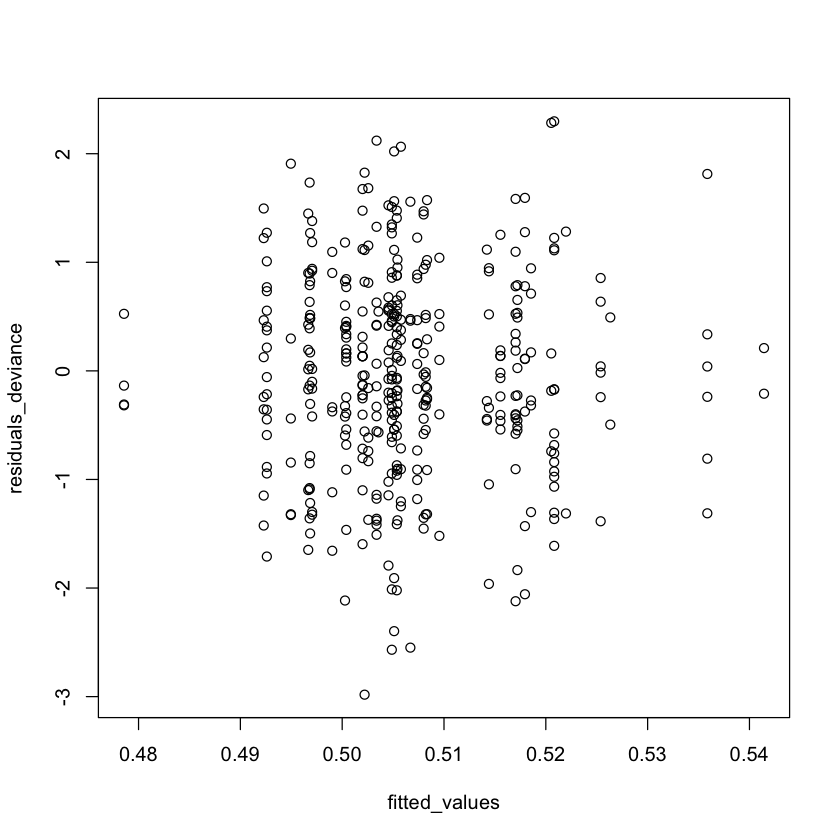

In [55]:
fitted_values <- predict(glm_model, data= df, type = "response")

plot( fitted_values, residuals_deviance)

### 2. Response distribution

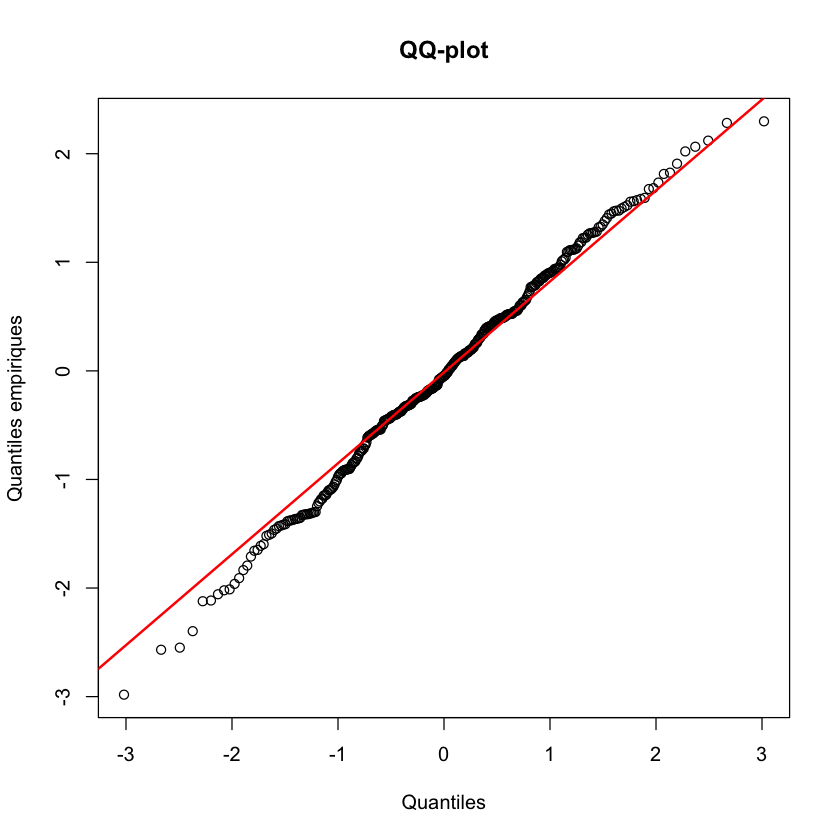

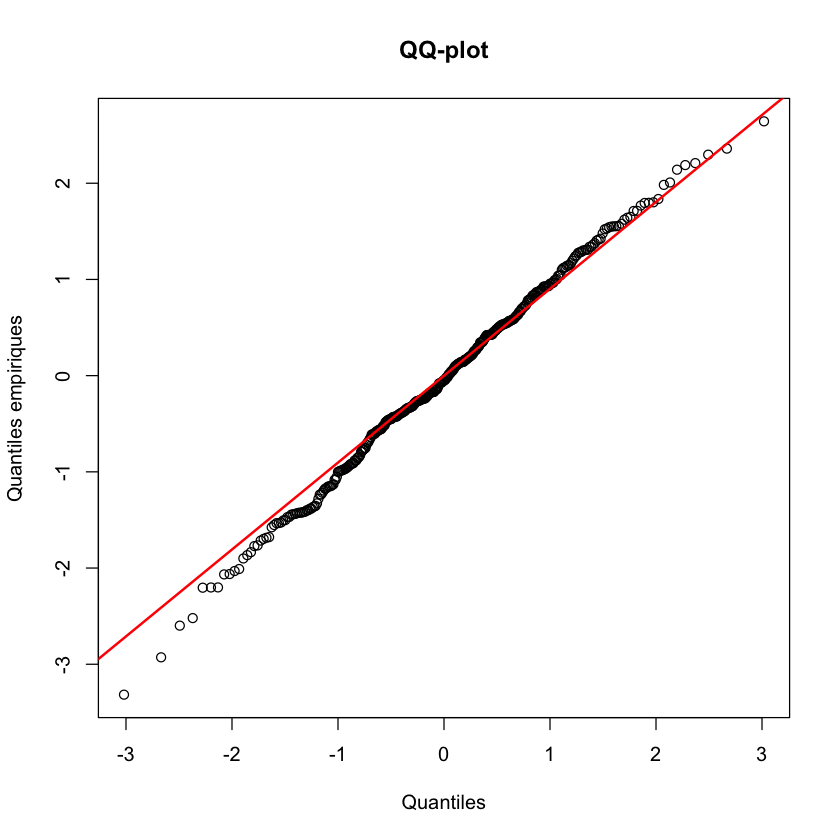

In [56]:
qqnorm(residuals_deviance, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std <- residuals_deviance / sqrt(1 - hatvalues(glm_model))

qqnorm(residuals_d_std, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_d_std, col = "red", lwd = 2)
# Not a big difference between them 


### 3. Independence (autocorrelation of the residuals)

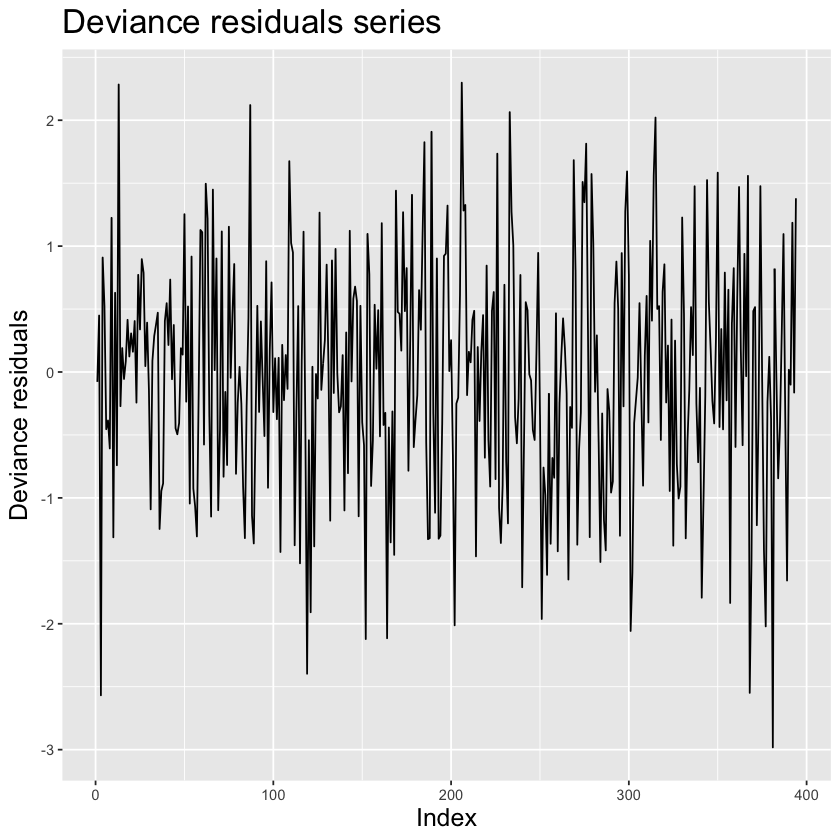

In [57]:
residuals_df <- data.frame(Residuals = residuals_deviance, Index = seq_along(residuals_deviance))
ggplot(residuals_df, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

### 4. Cook's distance

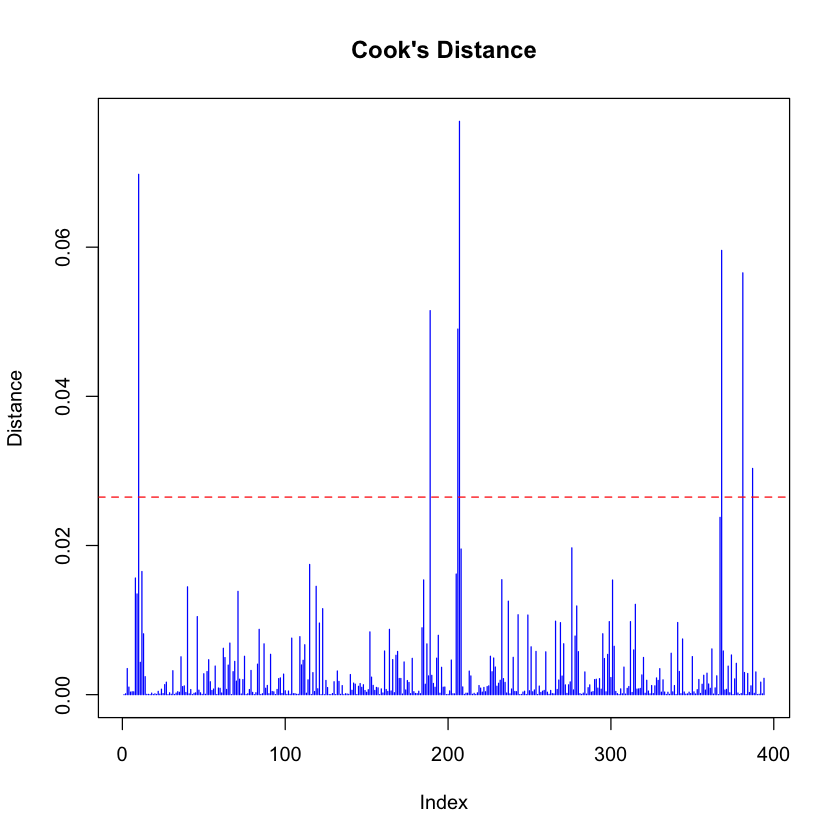

In [96]:
cooks_distance <- cooks.distance(glm_model)

plot(cooks_distance, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 8/(nrow(df)- 2*length(unique(df$person))), col = "red", lty = 2) # rule of thumb 

Since some people toss many more coins than others, some observations influence the model much more.

In [98]:
#threshold <- 4 / nrow(sampled_data_model1)
threshold <- 8/(nrow(df)- 2*length(unique(df$person)))
influential_points <- which(cooks_distance > threshold)
influential_data <- df[influential_points, ]
print(influential_data)

       y    m              person    coin start
10  1769 3463             madlenH 0.50EUR heads
203 1589 3103 FelipeFontanaVieira    2EUR heads
220 2292 4257          alexandraS    1MXN tails
221 1936 3635             madlenH 0.50EUR tails
396 1165 2423         AntonZoubek    5SEK tails
409  896 1914         SaraShabani    1EUR tails
415 2225 4386    FranziskaNippold 0.50EUR tails


## Performance

### ROC curve and AUC 

In [59]:
pred_probs<- predict(glm_model, type = "response")
print(mean(pred_probs))

[1] 0.5063592


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6928

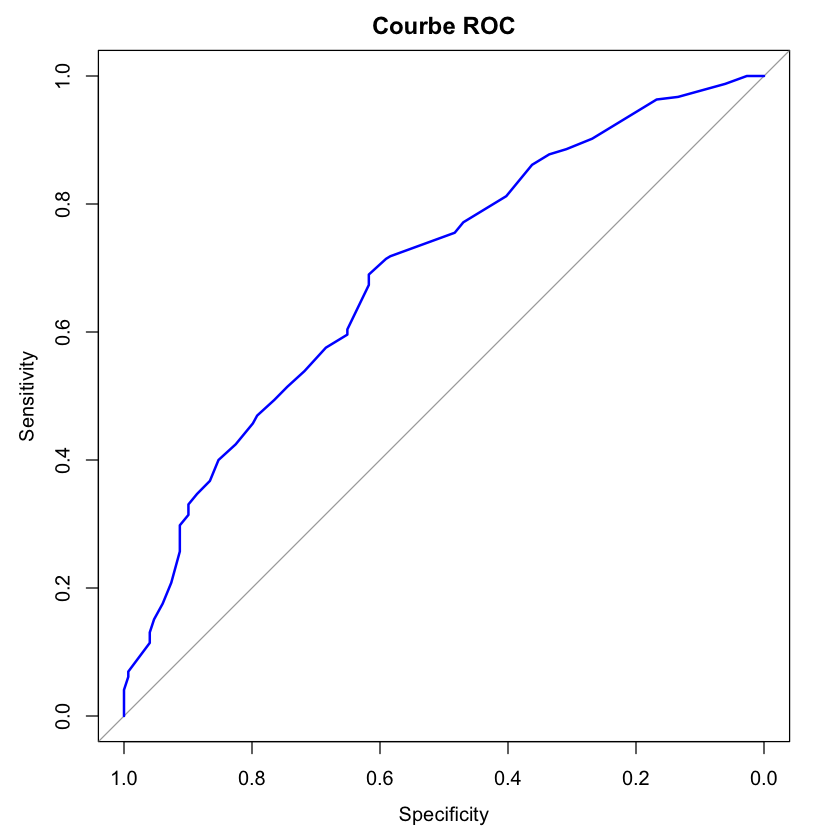

In [60]:
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

roc_curve <- roc(actual_classes, pred_probs)

plot(roc_curve, main = "Courbe ROC", col = "blue", lwd = 2)

auc(roc_curve)

### Confusion matrix and accuracy

In [ ]:
pred_probs <- predict(glm_model, type = "response")

pred_successes <- pred_probs * df$m

pred_classes <- ifelse(pred_successes > (df$m / 2), 1, 0)

actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

confusion_matrix <- table(Predicted = pred_classes, Actual = actual_classes)

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy: ", accuracy))

[1] "Accuracy:  0.67258883248731"


## Comparison

In [62]:
test_t <- t.test(pred_probs, pred_probs1 )
print(test_t)


	Welch Two Sample t-test

data:  pred_probs and pred_probs1
t = -0.40982, df = 767.49, p-value = 0.682
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.001758910  0.001151342
sample estimates:
mean of x mean of y 
0.5063592 0.5066630 



# WLS Model with all data

## Model Selection

In [63]:
wt = 1/(4*df$m)
wlsIntercept = lm(formula = y/m~1, data=df, weights=wt)
wlsPerson = lm(formula = y/m~1+person, data=df, weights=wt)
wlsCoin = lm(formula = y/m~1+coin, data=df, weights=wt)
wlsPersonCoin = lm(formula = y/m~1+person+coin, data=df, weights=wt)
wlsNested = lm(formula = y/m~1+person/coin, data=df, weights=wt)
wlsStart = lm(formula = y/m~1+start, data=df, weights=wt)
wlsCoinStart = lm(formula = y/m~1+coin+start, data=df, weights=wt)
wlsPersonStart = lm(formula = y/m~1+person+start, data=df, weights=wt)
wlsTotal = lm(formula = y/m~1+person+coin+start, data=df, weights=wt)
wlsTotalNested = lm(formula = y/m~1+person/coin+start, data=df, weights=wt)

In [64]:
best_model <- step(lm(formula = y/m~., data=df, weights=wt), direction="both")
summary(best_model)
best_model$anova

Start:  AIC=-5957.31
y/m ~ person + coin + start

         Df  Sum of Sq        RSS     AIC
- coin   40 1.0431e-05 7.9160e-05 -5981.6
- start   1 1.9150e-07 6.8920e-05 -5958.2
<none>                 6.8729e-05 -5957.3
- person 44 1.7523e-05 8.6252e-05 -5955.8

Step:  AIC=-5981.63
y/m ~ person + start

         Df  Sum of Sq        RSS     AIC
- start   1 1.8310e-07 7.9343e-05 -5982.7
<none>                 7.9160e-05 -5981.6
- person 45 2.0797e-05 9.9957e-05 -5979.7
+ coin   40 1.0431e-05 6.8729e-05 -5957.3

Step:  AIC=-5982.72
y/m ~ person

         Df  Sum of Sq        RSS     AIC
<none>                 7.9343e-05 -5982.7
+ start   1 1.8310e-07 7.9160e-05 -5981.6
- person 45 2.0780e-05 1.0012e-04 -5981.1
+ coin   40 1.0423e-05 6.8920e-05 -5958.2



Call:
lm(formula = y/m ~ person, data = df, weights = wt)

Weighted Residuals:
       Min         1Q     Median         3Q        Max 
-2.337e-03 -1.975e-04  3.065e-05  2.552e-04  1.415e-03 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.5150950  0.0068474  75.225  < 2e-16 ***
personAdrianKarami        -0.0164202  0.0105463  -1.557  0.12039    
personAndreeaZetea        -0.0214883  0.0103769  -2.071  0.03912 *  
personAntonZoubek         -0.0089222  0.0248358  -0.359  0.71963    
personArneJohn            -0.0176022  0.0101157  -1.740  0.08273 .  
personBohanFu             -0.0022966  0.0124429  -0.185  0.85367    
personChrisGabrielIslam   -0.0185928  0.0117518  -1.582  0.11453    
personEJ                  -0.0133461  0.0101130  -1.320  0.18780    
personFelipeFontanaVieira -0.0340544  0.0146193  -2.329  0.02041 *  
personFranziskaAssion      0.0181444  0.0109562   1.656  0.09860 .  
personFranziskaNippold    -0.02819

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,307,6.872901e-05,-5957.306
- coin,40,1.043116e-05,347,7.916016e-05,-5981.633
- start,1,1.830744e-07,348,7.934324e-05,-5982.723


In [65]:
# Is start significant?
anova(wlsPerson, wlsPersonStart) #-> Nope

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,348,7.934324e-05,NA,NA,NA,NA
2,347,7.916016e-05,1,1.830744e-07,0.80251,0.370965


In [ ]:
# Nest coins in persons?
anova(wlsPerson, wlsNested) #-> Nope
AIC(wlsPerson)
AIC(wlsNested)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,348,7.934324e-05,NA,NA,NA,NA
2,197,4.730347e-05,151,3.203977e-05,0.8836611,0.7876288


[1] -1760.539

[1] -1662.316

In [67]:
tab1 <- AIC(wlsIntercept, wlsPerson, wlsCoin, wlsPersonCoin, wlsNested, wlsStart, wlsCoinStart, wlsPersonStart, wlsTotal, wlsTotalNested)
tab2 <- AICc(wlsIntercept, wlsPerson, wlsCoin, wlsPersonCoin, wlsNested, wlsStart, wlsCoinStart, wlsPersonStart, wlsTotal, wlsTotalNested)
tab3 <- BIC(wlsIntercept, wlsPerson, wlsCoin, wlsPersonCoin, wlsNested, wlsStart, wlsCoinStart, wlsPersonStart, wlsTotal, wlsTotalNested)
tab_lr_selection <- cbind(tab1, tab2, tab3)
print(tab_lr_selection)

                df       AIC  df      AICc  df        BIC
wlsIntercept     2 -1758.886   2 -1758.855   2 -1750.9335
wlsPerson       47 -1760.539  47 -1747.499  47 -1573.6507
wlsCoin         43 -1734.798  43 -1723.987  43 -1563.8149
wlsPersonCoin   87 -1736.026  87 -1685.987  87 -1390.0837
wlsNested      198 -1662.316 198 -1258.193 198  -874.9984
wlsStart         3 -1757.540   3 -1757.479   3 -1745.6114
wlsCoinStart    44 -1733.646  44 -1722.299  44 -1558.6866
wlsPersonStart  48 -1759.449  48 -1745.815  48 -1568.5845
wlsTotal        88 -1735.122  88 -1683.765  88 -1385.2034
wlsTotalNested 199 -1661.867 199 -1251.557 199  -870.5727


## Model fit 

In [68]:
wls_model <- lm(formula = y/m~1+person, data=df, weights=wt)
summary(wls_model)
min(get_estimates(wls_model)$estimate[-1])
max(get_estimates(wls_model)$estimate[-1])
mean(get_estimates(wls_model)$estimate[-1])
sd(get_estimates(wls_model)$estimate[-1])
min(rstandard(wls_model))
max(rstandard(wls_model))


Call:
lm(formula = y/m ~ 1 + person, data = df, weights = wt)

Weighted Residuals:
       Min         1Q     Median         3Q        Max 
-2.337e-03 -1.975e-04  3.065e-05  2.552e-04  1.415e-03 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.5150950  0.0068474  75.225  < 2e-16 ***
personAdrianKarami        -0.0164202  0.0105463  -1.557  0.12039    
personAndreeaZetea        -0.0214883  0.0103769  -2.071  0.03912 *  
personAntonZoubek         -0.0089222  0.0248358  -0.359  0.71963    
personArneJohn            -0.0176022  0.0101157  -1.740  0.08273 .  
personBohanFu             -0.0022966  0.0124429  -0.185  0.85367    
personChrisGabrielIslam   -0.0185928  0.0117518  -1.582  0.11453    
personEJ                  -0.0133461  0.0101130  -1.320  0.18780    
personFelipeFontanaVieira -0.0340544  0.0146193  -2.329  0.02041 *  
personFranziskaAssion      0.0181444  0.0109562   1.656  0.09860 .  
personFranziskaNippold    -0.0

[1] -0.04325033

[1] 0.02732458

[1] -0.009092461

[1] 0.01364101

[1] -5.606478

[1] 3.700306

## Model Checking

### 1. Linearity

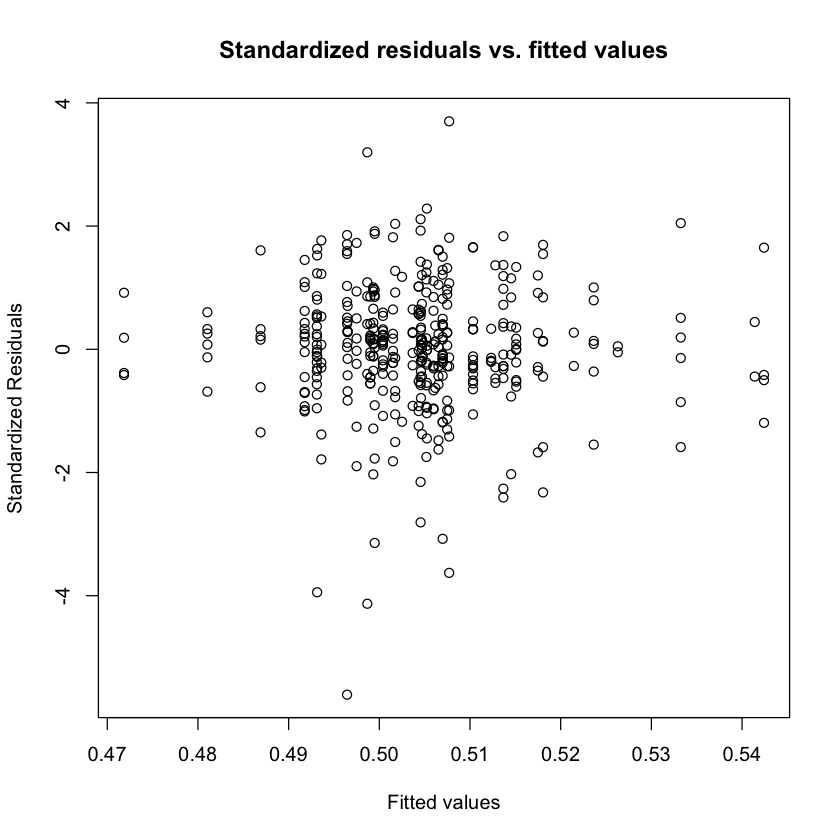

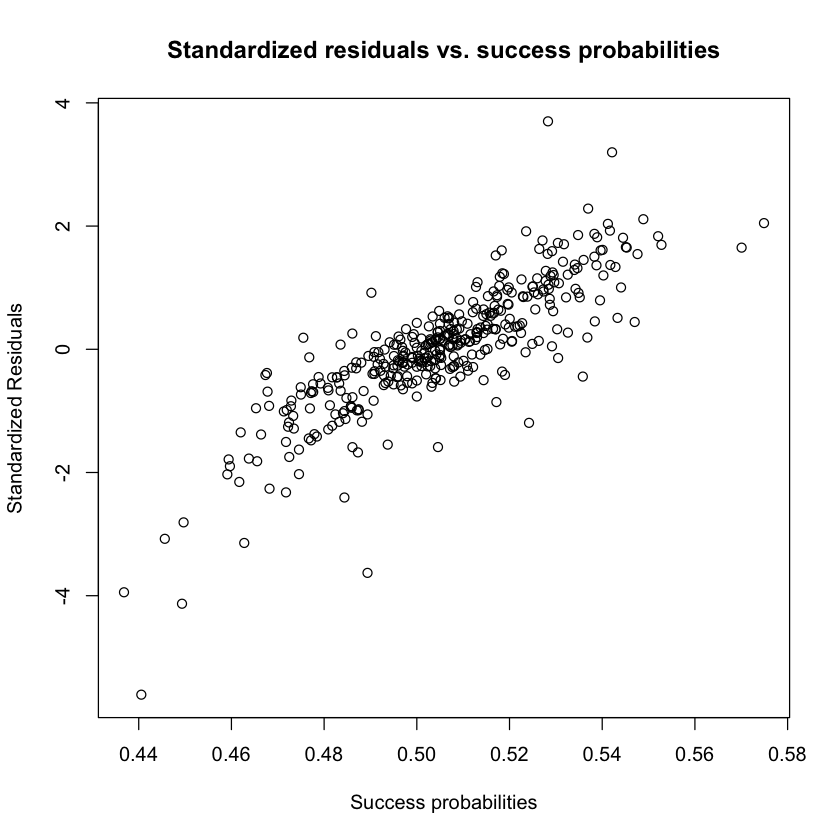

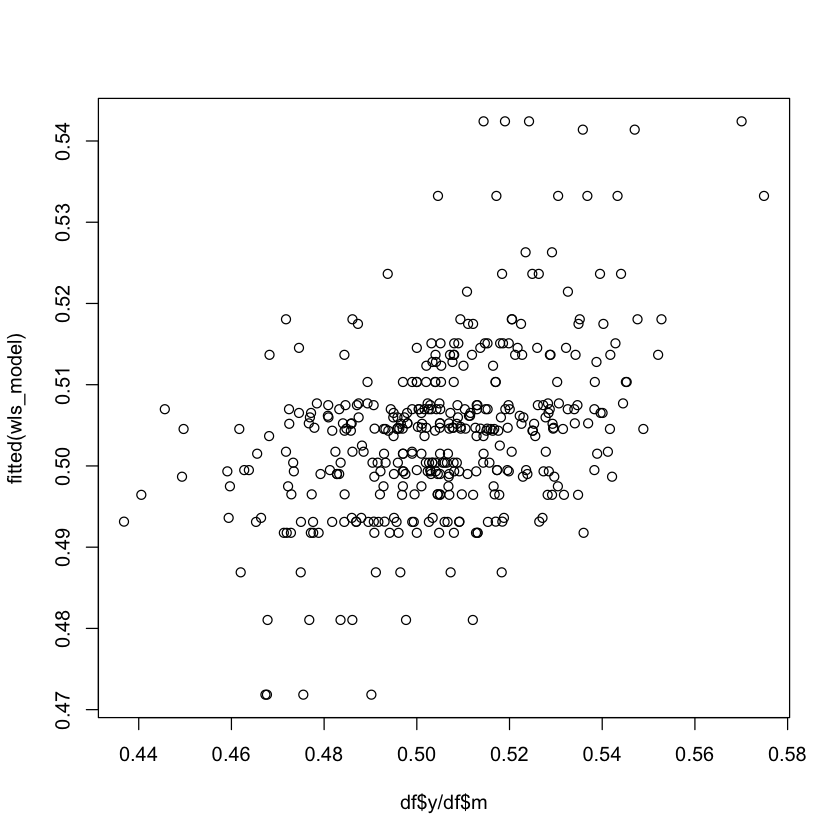

In [70]:
plot(fitted(wls_model), rstandard(wls_model), main="Standardized residuals vs. fitted values", xlab="Fitted values", ylab="Standardized Residuals")
plot(df$y/df$m, rstandard(wls_model), main="Standardized residuals vs. success probabilities", xlab="Success probabilities", ylab="Standardized Residuals")
plot(df$y/df$m, fitted(wls_model))

### 2. Response Distribution

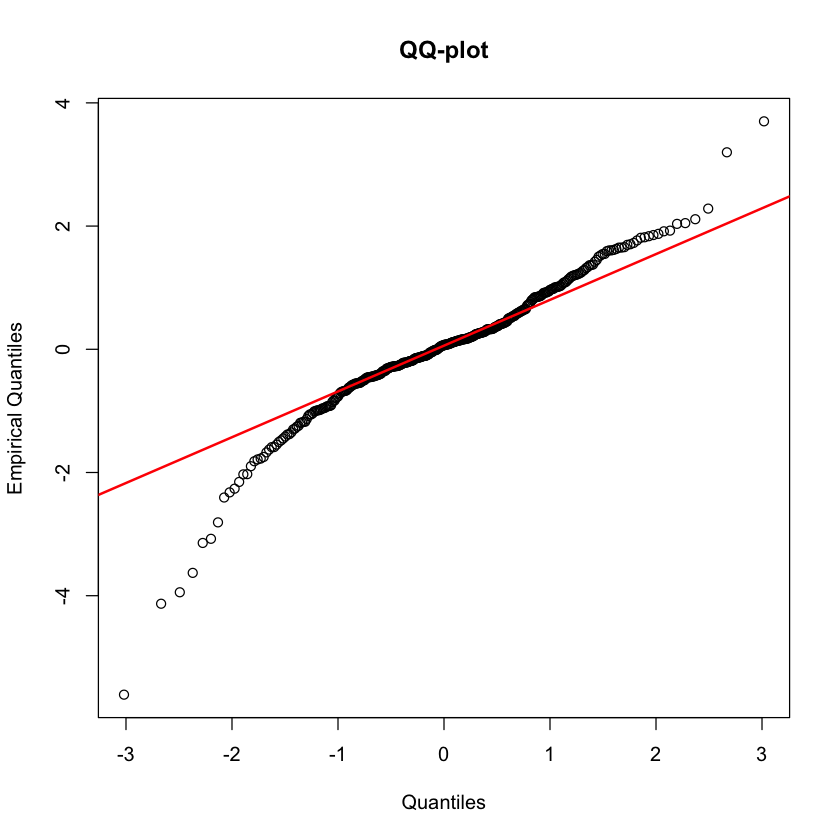

In [71]:
qqnorm(rstandard(wls_model), main = "QQ-plot", xlab = "Quantiles", ylab = "Empirical Quantiles")
qqline(rstandard(wls_model), col = "red", lwd = 2)

### 3. Independence

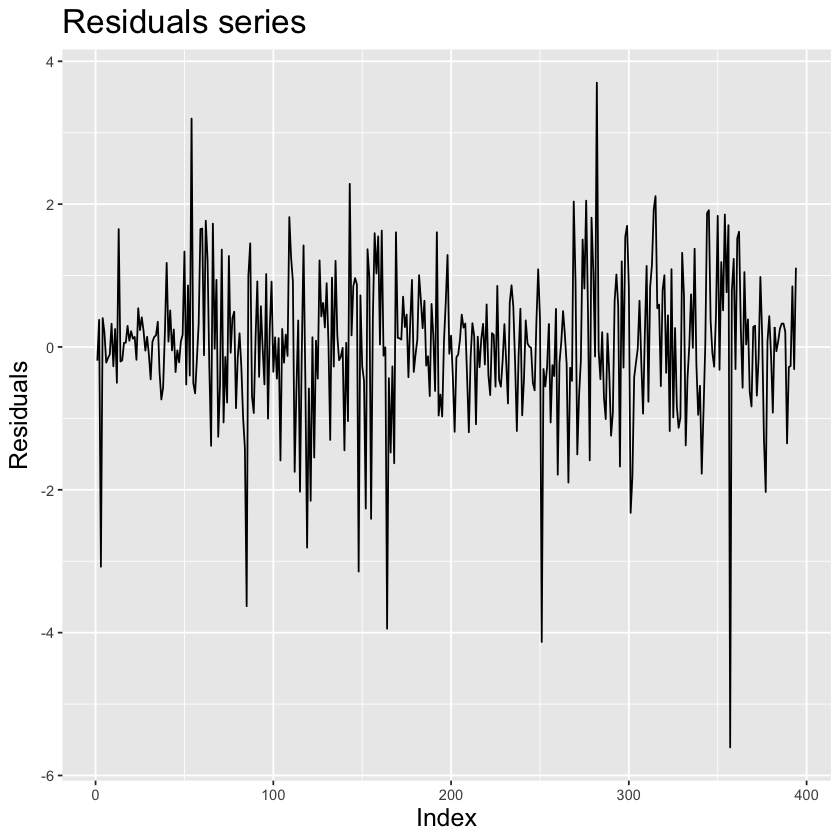

In [72]:
residuals_df <- data.frame(Residuals = rstandard(wls_model), Index = seq_along(rstandard(wls_model)))
ggplot(residuals_df, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Residuals") +
  ggtitle("Residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

### 4. Cooks Distance

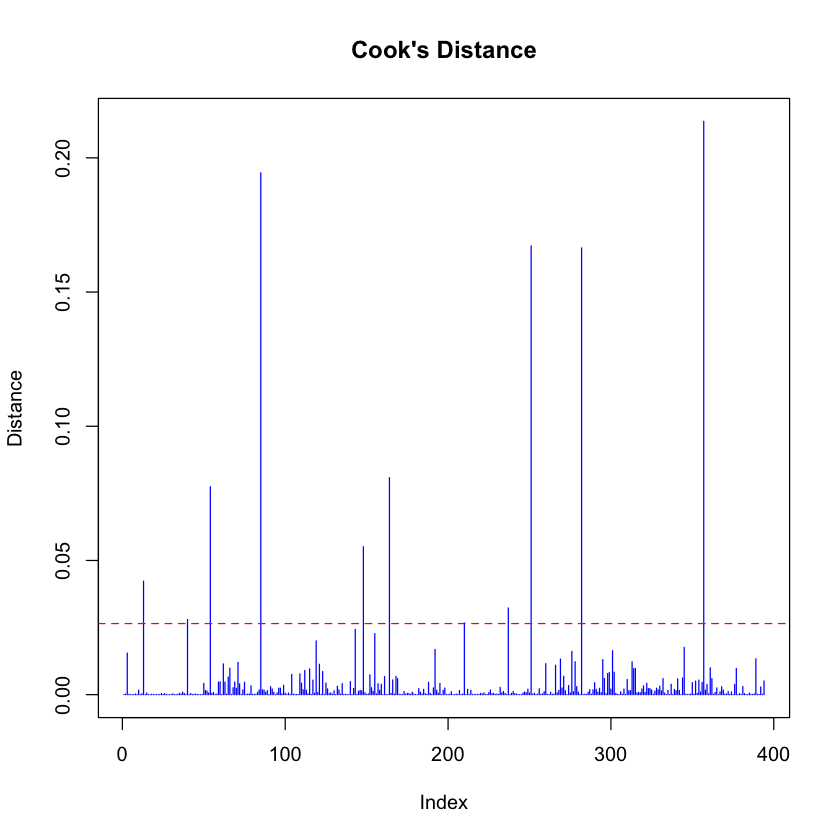

In [99]:
cooks_distance <- cooks.distance(wls_model)
plot(cooks_distance, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 8/(nrow(df)- 2*length(unique(df$person))), col = "red", lty = 2) # rule of thumb 

In [100]:
#threshold <- 4 / nrow(df)
threshold <- 8/(nrow(df)- 2*length(unique(df$person)))
influential_points <- which(cooks_distance > threshold)
influential_data <- df[influential_points, ]
print(influential_data)

      y   m            person    coin start
13  301 528             adamF 0.05EUR heads
40  188 363             irmaT    1EUR heads
54  148 273      AdrianKarami    1GBP heads
88   23  47   HannahArmstrong 0.25CAD heads
162  87 188 KatharinaKarnbach    2EUR heads
178 121 277       RietvanBork 0.50EUR heads
224 249 475             adamF 0.05EUR tails
251 165 338             irmaT    1EUR tails
265 102 227      AdrianKarami    1GBP tails
299  28  53   HannahArmstrong 0.25CAD tails
385  63 143 MichelleDonzallaz 0.05EUR tails


## Performance

In [75]:
pred_probs <- predict(wls_model, type = "response")
print(mean(pred_probs))

[1] 0.5042123


### ROC and AUC

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6904

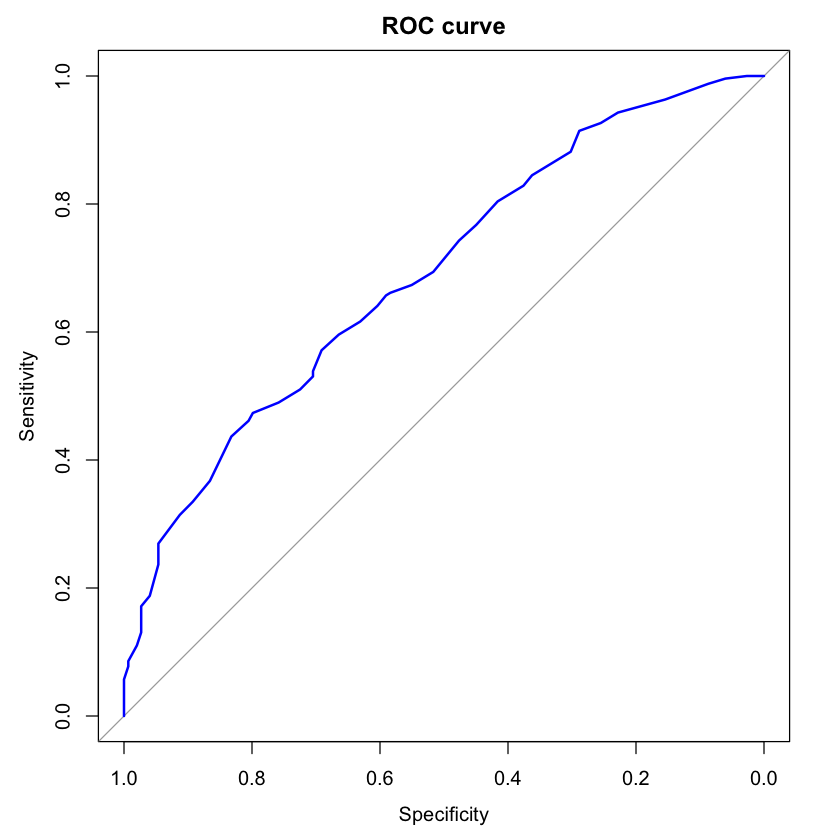

In [76]:
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)
roc_curve <- roc(actual_classes, pred_probs)
plot(roc_curve, main = "ROC curve", col = "blue", lwd = 2)
auc(roc_curve)

### Confusion matrix and accuracy

In [ ]:
pred_probs <- predict(wls_model, type = "response")

pred_successes <- pred_probs * df$m

pred_classes <- ifelse(pred_successes > (df$m / 2), 1, 0)

actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

confusion_matrix <- table(Predicted = pred_classes, Actual = actual_classes)

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy: ", accuracy))

[1] "Accuracy:  0.642131979695431"


# Mixed Model (Not here, but in extra R file)

The mixed model fit can be found in the script R 'mixedModel.R'